# Initial Setup

In [1]:
import warnings
warnings.filterwarnings("ignore")
import sys
from herdingspikes.hs2 import HSDetection
from herdingspikes.probe import HierlmannVisapyEmulationProbe
import matplotlib.pyplot as plt
import h5py
import numpy as np
from PIL import Image

%matplotlib inline

np.random.seed(0)

In [2]:
# raw data location
data_path = 'visapy_data.npy'

In [3]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils import data

torch.cuda.set_device(3)
torch.manual_seed(0)

In [4]:
import cv2
import copy

# Spike Detection

In [5]:
# detection parameters
to_localize = True
cutout_start = 14
cutout_end = 36
threshold = 24
file_directory = 'results/'
file_name = 'ProcessedSpikes_visapy'

Probe = HierlmannVisapyEmulationProbe('visapy_data.npy')
H = HSDetection(Probe, to_localize, cutout_start, cutout_end, threshold,
                maa=0, maxsl=12, minsl=3, ahpthr=0, out_file_name=file_name, 
                file_directory_name=file_directory, save_all=True)

H.DetectFromRaw()
H.LoadDetected()

File size: 122400102
Number of channels: 102
# Sampling rate: 32000
# Localization On
# Not Masking any Channels
# Writing out extended detection info
# Number of recorded channels: 102
# Analysing frames: 1200001, Seconds:37.50003125
# Frames before spike in cutout: 32
# Frames after spike in cutout: 70
# tcuts: 44 59
# tInc: 50000
# Analysing 50000 frames; from -44 to 50059
# Analysing 50000 frames; from 49956 to 100059
# Analysing 50000 frames; from 99956 to 150059
# Analysing 50000 frames; from 149956 to 200059
# Analysing 50000 frames; from 199956 to 250059
# Analysing 50000 frames; from 249956 to 300059
# Analysing 50000 frames; from 299956 to 350059
# Analysing 50000 frames; from 349956 to 400059
# Analysing 50000 frames; from 399956 to 450059
# Analysing 50000 frames; from 449956 to 500059
# Analysing 50000 frames; from 499956 to 550059
# Analysing 50000 frames; from 549956 to 600059
# Analysing 50000 frames; from 599956 to 650059
# Analysing 50000 frames; from 649956 to 700059

# Loading and Setting up Ground Truths

## Waveforms

In [6]:
data = np.load('visapy_data.npy')

In [7]:
frame_set = data.reshape((1200001,102))
print("Frame shape: ", frame_set.shape)
print("Whole Dataset: ", frame_set)

Frame shape:  (1200001, 102)
Whole Dataset:  [[  4 -18   3 ...   5 -11  -4]
 [  3 -26  -4 ...   6 -13   6]
 [  3 -25  -6 ...   5 -18   3]
 ...
 [  1  32  -5 ...   7   2   0]
 [-17  27  -9 ...  12  -1  11]
 [-13  21  -8 ...  15   0  10]]


## Ground Truths

In [8]:
somapos = np.loadtxt('ViSAPy_somapos.gdf')
ground_truth = np.loadtxt('ViSAPy_ground_truth.gdf')

ground_truth = ground_truth.astype(int)
somapos = np.array([somapos[:,0], somapos[:,1]])

print(ground_truth.shape)
print(somapos.shape)

(64441, 2)
(2, 56)


## Generate Channel Time Combinations

In [9]:
list_times = H.spikes['t'].tolist()
list_ch = H.spikes['ch'].tolist()

x = H.spikes['x'].tolist()
y = H.spikes['y'].tolist()

print(len(x), len(list_times))

# A list of all time and channel combinations which have spikes
list_times_ch = []
for i in range(len(list_times)):
    list_times_ch.append((list_times[i], list_ch[i]))

19341 19341


## Electrode Positions

In [10]:
x_path = 'z_integer.npy'
y_path = 'y_integer.npy'
elec_x_int = np.load(x_path)
elec_y_int = np.load(y_path)

In [11]:
ky = 9 / np.max(np.diff(sorted(elec_y_int)))
elec_x = elec_x_int * ky
elec_y = elec_y_int * ky
elec_x -= np.min(elec_x)
elec_y -= np.min(elec_y)

In [12]:
datapoints = []
for i in range(len(elec_x)):
    datapoints.append([elec_x[i], elec_y[i]])
datapoints = np.asarray(datapoints)
print(datapoints)

[[ 59.54058193 179.98346095]
 [  0.         233.97886677]
 [ 74.42572741 242.97794793]
 [ 59.54058193  17.99816233]
 [ 29.77029096  35.99632466]
 [ 59.54058193 143.98621746]
 [ 44.65543645 242.97794793]
 [ 14.88514548 296.97243492]
 [ 74.42572741  44.99540582]
 [  0.         107.9898928 ]
 [ 29.77029096 143.98621746]
 [  0.          17.99816233]
 [ 59.54058193  53.99448698]
 [ 44.65543645  80.99264931]
 [ 74.42572741 170.98437979]
 [ 44.65543645 206.98070444]
 [  0.         197.98162328]
 [ 14.88514548 278.97427259]
 [ 44.65543645 296.97243492]
 [ 14.88514548  44.99540582]
 [ 59.54058193  89.99173047]
 [  0.         215.9797856 ]
 [ 74.42572741 278.97427259]
 [ 14.88514548  26.99724349]
 [ 44.65543645  44.99540582]
 [ 44.65543645  98.99081164]
 [ 74.42572741 152.98621746]
 [ 29.77029096   0.        ]
 [ 74.42572741  26.99724349]
 [  0.          53.99448698]
 [ 44.65543645 134.98713629]
 [ 44.65543645  62.99356815]
 [ 59.54058193 287.97335375]
 [ 59.54058193 215.9797856 ]
 [ 59.54058193

In [36]:
location = {}

x = H.spikes['x'].tolist()
y = H.spikes['y'].tolist()

for i in range(len(list_times)):
    location[(list_times[i], list_ch[i])] = (x[i], y[i])

# Generate Images - ONLY USE FIRST TIME!

# Loading Images

In [13]:
# Creates a correspondence between HS2 and Ground Truth

new_list_times_ch = []
new_location = {}
neuron_channels = {}

for i, val in enumerate(list_times_ch):
    for ind, j in enumerate(ground_truth[:, 1]):
        if val[0] in range(j-2, j+2):
            neuron = ground_truth[ind, 0] - 1
            new_list_times_ch.append((val[0], val[1]))
            new_location[(val[0], val[1])] = (somapos[0, neuron], somapos[1, neuron])
            try:
                neuron_channels[neuron].append((val[0], val[1]))
            except:
                neuron_channels[neuron] = [(val[0], val[1])]
            break

In [14]:
image_data = {}

for i in range(len(new_list_times_ch)):
    filename = "frames_small_attention/frame_"+str(new_list_times_ch[i][0])+"_"+str(new_list_times_ch[i][1])+".png"
    temp_pic = cv2.imread(filename)
    temp_pic = cv2.cvtColor(temp_pic, cv2.COLOR_RGB2GRAY)
    temp_pic = temp_pic/255
    image_data[(new_list_times_ch[i][0], new_list_times_ch[i][1])] = temp_pic

# Removing False Triggers from Neuron List

In [15]:
# Filter only relevant frames
from collections import Counter

updated_neuron_channels = {}
for i in neuron_channels.keys():
    updated_neuron_channels[i] = []
    elec_list = np.array(neuron_channels[i])[:, 1]
    occ = Counter(elec_list)
    final_elec_list = []
    for d in occ.keys():
        if occ[d] > 80:
            final_elec_list.append(d)
    for j in final_elec_list:
        for k in neuron_channels[i]:
            if k[1] == j:
                updated_neuron_channels[i].append(k)

In [16]:
# New list of times and channels

list_loc_ch = []
for i in updated_neuron_channels.values():
    list_loc_ch = list_loc_ch + i
print(len(list_loc_ch))

8977


In [17]:
import random

random.seed(0)
random.shuffle(list_loc_ch)

train_lim = (int)(0.75*len(list_loc_ch))
val_lim = (int)(0.80*len(list_loc_ch))

list_times_ch_train = list_loc_ch[:train_lim]
list_times_ch_val = list_loc_ch[train_lim:val_lim]
list_times_ch_test = list_loc_ch[val_lim:]

print(len(list_times_ch_train),len(list_times_ch_val), len(list_times_ch_test))

6732 449 1796


In [28]:
# No of examples for each neuron
for i in updated_neuron_channels.keys():
    if len(updated_neuron_channels[i]) != 0:
        print(i, '-', len(updated_neuron_channels[i]), end = ', ')

46 - 775, 41 - 631, 12 - 543, 49 - 398, 27 - 497, 43 - 576, 28 - 276, 53 - 406, 22 - 306, 21 - 213, 10 - 507, 34 - 529, 11 - 307, 48 - 311, 47 - 179, 18 - 338, 38 - 277, 32 - 207, 13 - 436, 42 - 434, 40 - 302, 37 - 280, 8 - 128, 15 - 121, 

In [30]:
# Channels associated to each neuron
for i in updated_neuron_channels.keys():
    list_oc = []
    for j in updated_neuron_channels[i]:
        list_oc.append(j[1])
    print(i, '-', set(list_oc), end = ', ')

46 - {48, 58}, 41 - {81, 65, 84}, 12 - {68}, 49 - {17}, 27 - {72, 26}, 43 - {95}, 45 - set(), 28 - {60}, 52 - set(), 53 - {18, 7}, 22 - {97, 98}, 21 - {46}, 10 - {93}, 34 - {66, 37}, 5 - set(), 35 - set(), 11 - {96, 28}, 50 - set(), 48 - {57}, 47 - {58}, 54 - set(), 18 - {13}, 38 - {33}, 9 - set(), 32 - {71}, 13 - {35}, 42 - {84, 53}, 1 - set(), 40 - {1}, 31 - set(), 37 - {41}, 29 - set(), 2 - set(), 39 - set(), 55 - set(), 24 - set(), 17 - set(), 0 - set(), 6 - set(), 8 - {11}, 26 - set(), 7 - set(), 23 - set(), 36 - set(), 14 - set(), 3 - set(), 51 - set(), 25 - set(), 30 - set(), 15 - {62}, 19 - set(), 33 - set(), 44 - set(), 20 - set(), 16 - set(), 4 - set(), 

# Defining the CNN

In [90]:
#torch.cuda.set_device(1)

class LocatorCNN(nn.Module):
    def __init__(self, dilate=1):
        super(LocatorCNN, self).__init__()
        self.conv_layer1 = nn.Conv2d(1, 16, kernel_size=5, stride=1)
        self.conv_layer2 = nn.Conv2d(16, 32, kernel_size=5, stride=1, dilation=dilate)

        self.conv_layer3 = nn.Conv2d(32, 64, kernel_size=3, stride=1)
        self.conv_layer4 = nn.Conv2d(64, 128, kernel_size=3, stride=1)
        self.conv_layer6 = nn.Conv2d(128, 256, kernel_size=3, stride=1, dilation=dilate)
    
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        
        self.drop2 = nn.Dropout2d(p=0.2) #0.1
        self.drop1 = nn.Dropout(p=0.5) #0.05
        
        self.activation_layer_2d = nn.ReLU()
        self.activation_layer = nn.ELU()
        
        #self.linear_0 = nn.Linear(107648, 4096)
        self.linear_1 = nn.Linear(2304, 1024) #with maxpooling
        #self.linear_1 = nn.Linear(9750528, 2048)
        self.linear_2 = nn.Linear(1024, 512)
        self.linear_3 = nn.Linear(512, 128)
        self.linear_4 = nn.Linear(128, 32)
        self.linear_5 = nn.Linear(33, 8)
        self.linear_6 = nn.Linear(8, 2)
    
    def forward(self, x, dim, channel):

        out = self.conv_layer1(x)
        out = self.activation_layer_2d(out)
        #print(out.shape)
        out = self.conv_layer2(out)
        #print(out.shape)
        out = self.activation_layer_2d(out)
        out = self.maxpool(out)
        out = self.drop2(out)
        #print(out.shape)
        
        out = self.conv_layer3(out)
        out = self.activation_layer_2d(out)
        #print(out.shape)
        out = self.conv_layer4(out)
        out = self.activation_layer_2d(out)
        out = self.maxpool(out)
        out = self.drop2(out)
        #print(out.shape)
        
        out = self.conv_layer6(out)
        out = self.activation_layer_2d(out)
        out = self.maxpool(out)
        #out = self.drop2(out)
        #print(out.shape)
        
        out = out.view(dim, -1)
        #out = self.linear_0(out)
        #out = self.activation_layer(out)
        #out = self.drop1(out)
        out = self.linear_1(out)
        out = self.activation_layer(out)
        out = self.drop1(out)
        out = self.linear_2(out)
        out = self.activation_layer(out)
        out = self.linear_3(out)
        out = self.activation_layer(out)
        #out = self.drop1(out)
        out = self.linear_4(out)
        out = self.activation_layer(out)
        #print(out.shape, channel.shape)
        out = torch.cat((out, channel), dim=1)
        out = self.linear_5(out)
        out = self.activation_layer(out)
        out = self.linear_6(out)
        
        return out

In [86]:
cnn_1 = torch.load('models/cnn_models/loc_cnn_unbranched.pt', map_location=lambda storage, loc: storage)

In [87]:
#Executing the CNN

x = np.zeros((len(list_times_ch_test), 54, 54))
ch = np.zeros((len(list_times_ch_test), 1))
loc = np.zeros((len(list_times_ch_test), 2))

for i in range(len(list_times_ch_test)):
        pointer = list_times_ch_test[i]
        x[i, :, :] = image_data[pointer]
        dim = x.shape[0]
        ch[i, :] = np.array(pointer[1])
x = torch.from_numpy(x).float()
x = x.view(len(list_times_ch_test), -1, 54, 54)
ch = torch.from_numpy(ch).float()
#---------FORWARD------------#
out = cnn_1.forward(x, dim, ch)
out = torch.tensor(out).float()
out = (out.data).cpu().numpy()

# Median of results for neurons

In [88]:
cnn_loc = []
com_loc = []
true_loc = []

# Use 12, 27, 43, 28, 53

for i, val in enumerate(updated_neuron_channels[53]):
    for j, index in enumerate(list_times_ch_test):
        if val == index:
            com_loc.append(location[val])
            cnn_loc.append(out[j])
            true_loc.append(new_location[val])
cnn_loc = np.array(cnn_loc)
com_loc = np.array(com_loc)
true_loc = np.array(true_loc)
#print(cnn_loc)
#print(com_loc)
print("True Location: ", true_loc[0, :])

print("CNN: ", np.median(cnn_loc, axis=0), np.var(cnn_loc, axis=0))
print("COM: ", np.median(com_loc, axis=0), np.var(com_loc, axis=0))

True Location:  [ 29.19640478 304.72127251]
CNN:  [ 28.74001 303.08298] [ 5.1692953 57.14179  ]
COM:  [ 30.377 287.02 ] [12.59309593  2.40858844]


# Plotting Outputs

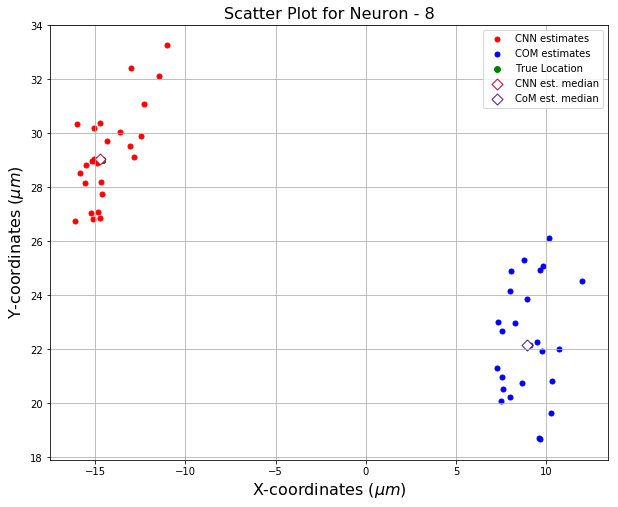

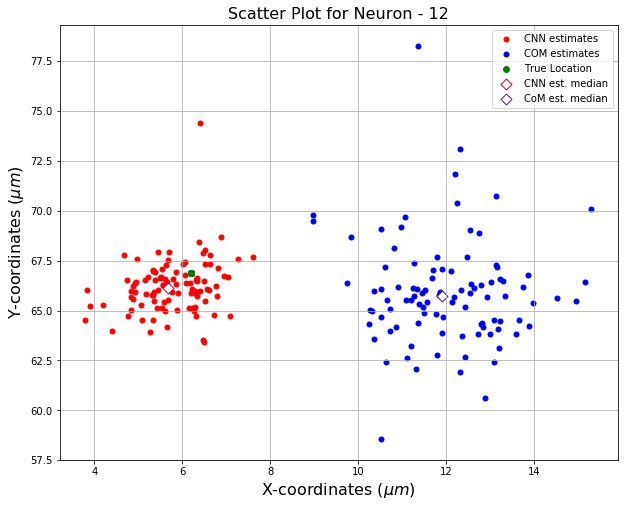

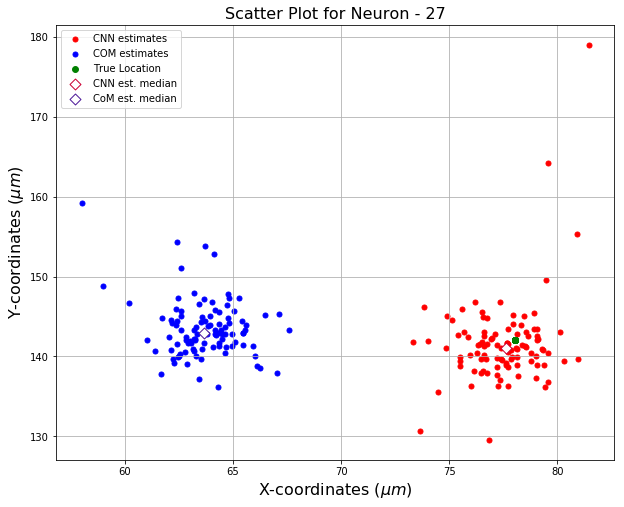

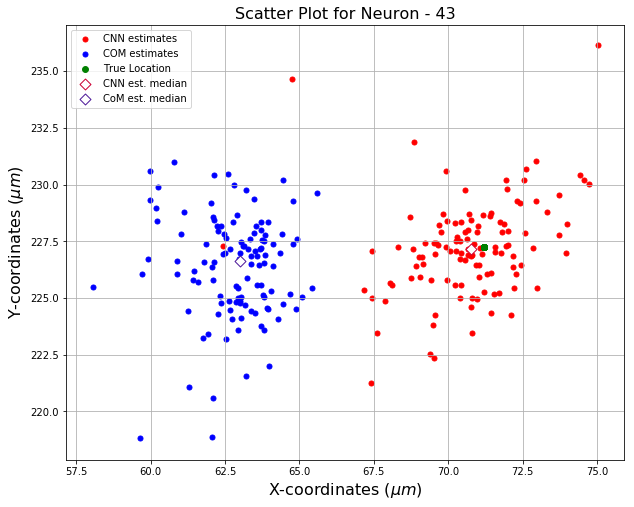

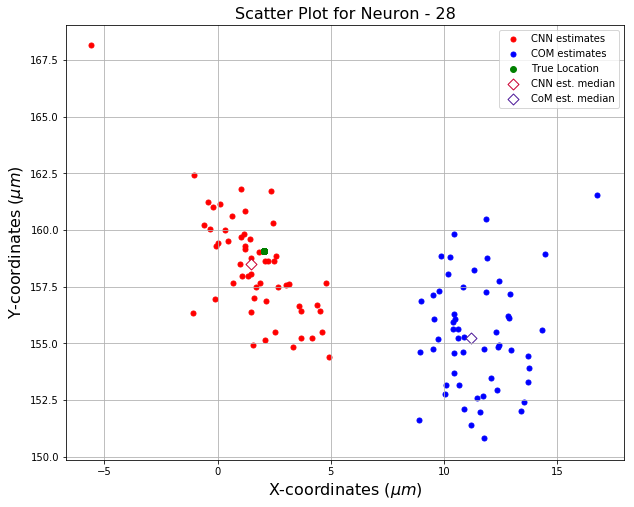

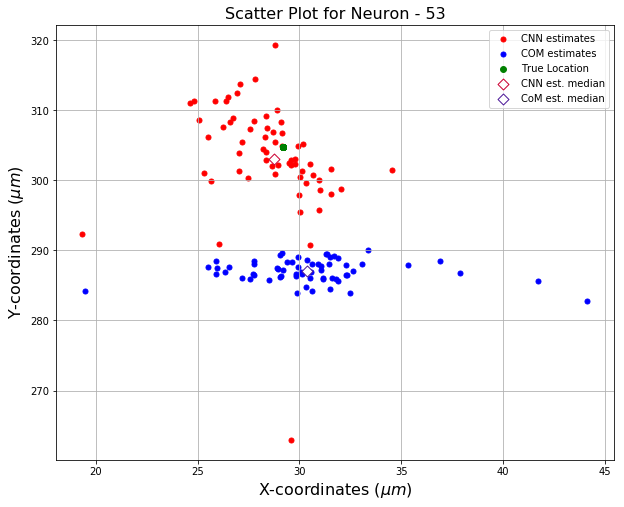

In [89]:
# remove the plt.plot lineif you do not want to see orientations
for looper in [8, 12, 27, 43, 28, 53]:
    cnn_loc = []
    com_loc = []
    true_loc = []

    for i, val in enumerate(updated_neuron_channels[looper]):
        for j, index in enumerate(list_times_ch_test):
            if val == index:
                com_loc.append(location[val])
                cnn_loc.append(out[j])
                true_loc.append(new_location[val])
    cnn_loc = np.array(cnn_loc)
    com_loc = np.array(com_loc)
    true_loc = np.array(true_loc)
    #print(cnn_loc)
    #print(com_loc)
    
    #print("True Location: ", true_loc[0, :])
    #print("CNN: ", np.median(cnn_loc, axis=0), np.var(cnn_loc, axis=0))
    #print("COM: ", np.median(com_loc, axis=0), np.var(com_loc, axis=0))
    cnn_median = np.median(cnn_loc, axis=0)
    com_median = np.median(com_loc, axis=0)

    fig = plt.figure(figsize=(10,8))
    plt.scatter(cnn_loc[:, 0], cnn_loc[:, 1], c = 'r', s=25, label='CNN estimates')
    plt.scatter(com_loc[:, 0], com_loc[:, 1], c = 'b', s=25, label='COM estimates')
    plt.scatter(true_loc[:, 0], true_loc[:, 1], c = 'g', s=35, label='True Location')
    plt.scatter(cnn_median[0], cnn_median[1], facecolors='white', edgecolors=(0.8, 0, 0.2), s=60, marker="D", label='CNN est. median')
    plt.scatter(com_median[0], com_median[1], facecolors='white', edgecolors=(0.3, 0.1, 0.6), s=60, marker="D", label='CoM est. median')
    #plt.plot([cnn_median[0], com_median[0]], [cnn_median[1], com_median[1]], 'y', label='Orientation',  linewidth=3.8)
    plt.xlabel(u'X-coordinates (${\mu}m$)', fontsize=16)
    plt.ylabel(u'Y-coordinates (${\mu}m$)', fontsize=16)
    plt.legend()
    plt.title('Scatter Plot for Neuron - '+str(looper), fontsize=16)
    plt.grid()
    plt.show()
    #print(np.median(cnn_loc, axis=0), np.median(com_loc, axis=0))

    fig.savefig("neuron_loc_"+str(looper)+".pdf", bbox_inches='tight')

# No channel models

In [75]:
#torch.cuda.set_device(1)

class LocatorCNN_NC(nn.Module):
    def __init__(self, dilate=1):
        super(LocatorCNN_NC, self).__init__()
        self.conv_layer1 = nn.Conv2d(1, 16, kernel_size=5, stride=1)
        self.conv_layer2 = nn.Conv2d(16, 32, kernel_size=5, stride=1, dilation=dilate)

        self.conv_layer3 = nn.Conv2d(32, 64, kernel_size=3, stride=1)
        self.conv_layer4 = nn.Conv2d(64, 128, kernel_size=3, stride=1)
        self.conv_layer6 = nn.Conv2d(128, 256, kernel_size=3, stride=1, dilation=dilate)
    
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        
        self.drop2 = nn.Dropout2d(p=0.2) #0.1
        self.drop1 = nn.Dropout(p=0.5) #0.05
        
        self.activation_layer_2d = nn.ReLU()
        self.activation_layer = nn.ELU()
        
        #self.linear_0 = nn.Linear(107648, 4096)
        self.linear_1 = nn.Linear(2304, 1024) #with maxpooling
        #self.linear_1 = nn.Linear(9750528, 2048)
        self.linear_2 = nn.Linear(1024, 512)
        self.linear_3 = nn.Linear(512, 128)
        self.linear_4 = nn.Linear(128, 32)
        self.linear_5 = nn.Linear(32, 8)
        self.linear_6 = nn.Linear(8, 2)
    
    def forward(self, x, dim, channel):

        out = self.conv_layer1(x)
        out = self.activation_layer_2d(out)
        out = self.conv_layer2(out)
        out = self.activation_layer_2d(out)
        out = self.maxpool(out)
        out = self.drop2(out)
        
        out = self.conv_layer3(out)
        out = self.activation_layer_2d(out)
        out = self.conv_layer4(out)
        out = self.activation_layer_2d(out)
        out = self.maxpool(out)
        out = self.drop2(out)
        
        out = self.conv_layer6(out)
        out = self.activation_layer_2d(out)
        out = self.maxpool(out)
        
        out = out.view(dim, -1)
        out = self.linear_1(out)
        out = self.activation_layer(out)
        out = self.drop1(out)
        out = self.linear_2(out)
        out = self.activation_layer(out)
        out = self.linear_3(out)
        out = self.activation_layer(out)
        out = self.linear_4(out)
        out = self.activation_layer(out)
        out = self.linear_5(out)
        out = self.activation_layer(out)
        out = self.linear_6(out)
        
        return out

In [80]:
cnn_1 = torch.load('models/cnn_models/loc_cnn_nochannel.pt', map_location=lambda storage, loc: storage)

In [81]:
#Executing the CNN

x = np.zeros((len(list_times_ch_test), 54, 54))
ch = np.zeros((len(list_times_ch_test), 1))
loc = np.zeros((len(list_times_ch_test), 2))

for i in range(len(list_times_ch_test)):
        pointer = list_times_ch_test[i]
        x[i, :, :] = image_data[pointer]
        dim = x.shape[0]
        ch[i, :] = np.array(pointer[1])
x = torch.from_numpy(x).float()
x = x.view(len(list_times_ch_test), -1, 54, 54)
ch = torch.from_numpy(ch).float()
#---------FORWARD------------#
out = cnn_1.forward(x, dim, ch)
out = torch.tensor(out).float()
out = (out.data).cpu().numpy()

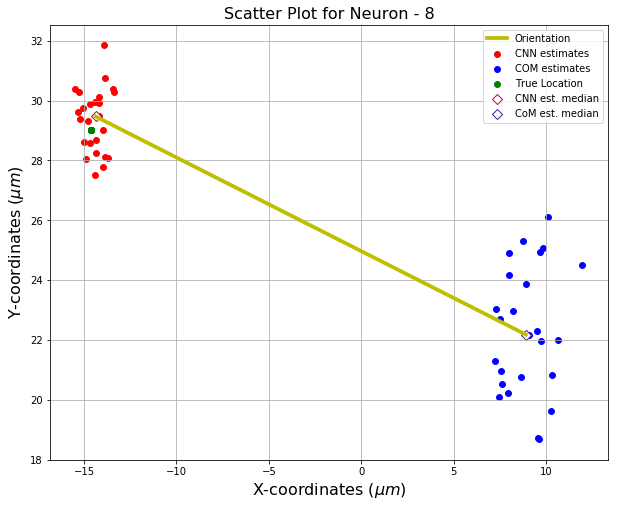

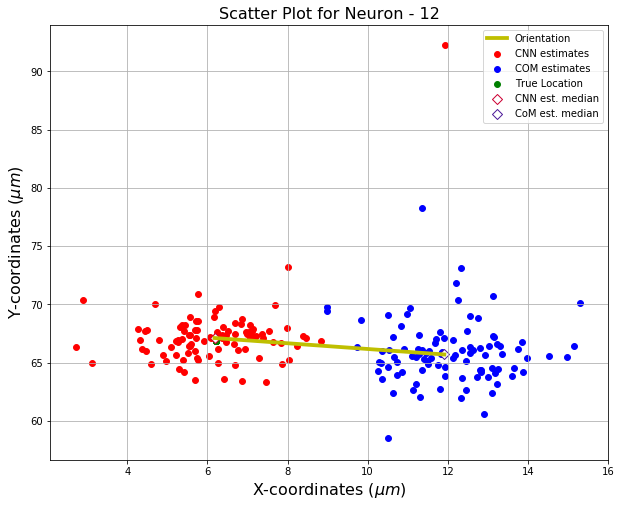

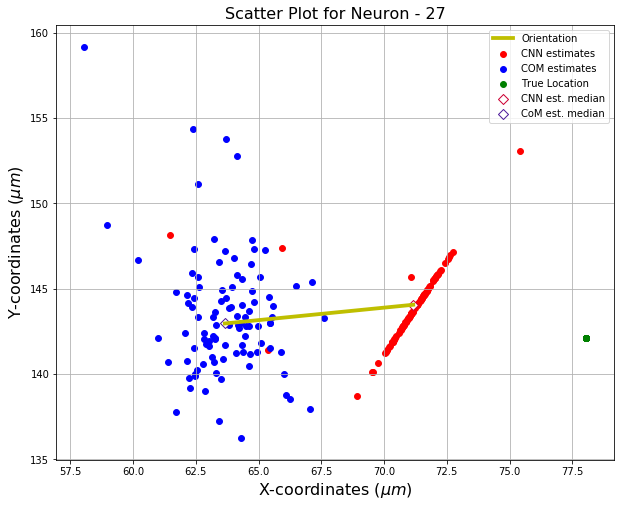

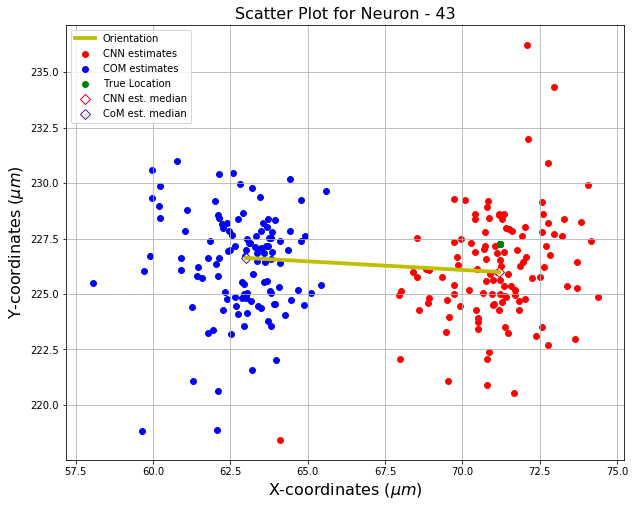

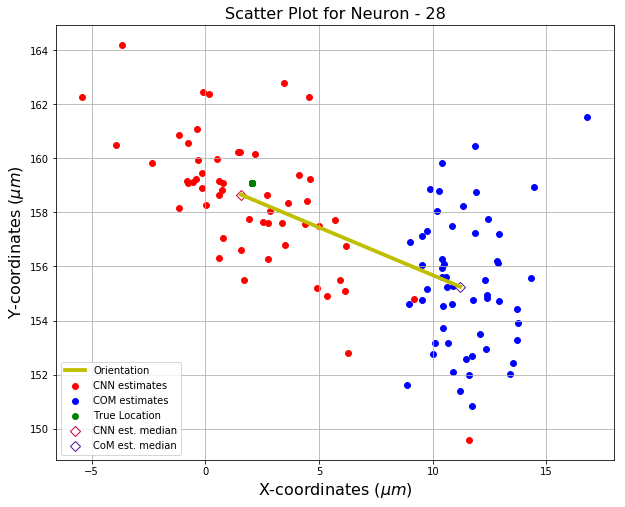

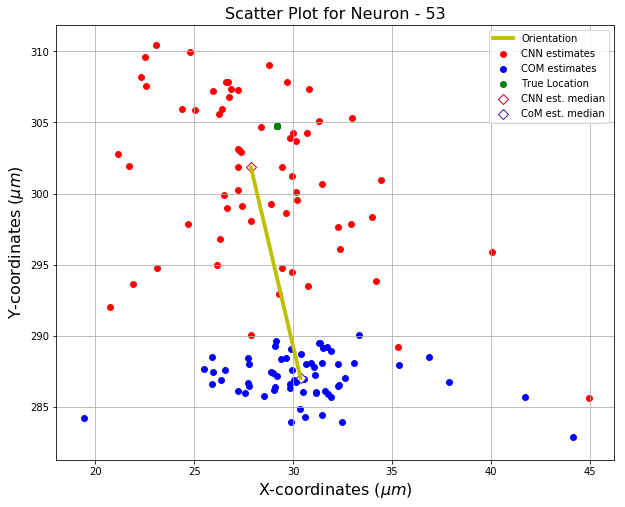

In [85]:
# remove the plt.plot lineif you do not want to see orientations
for looper in [8, 12, 27, 43, 28, 53]:
    cnn_loc = []
    com_loc = []
    true_loc = []

    for i, val in enumerate(updated_neuron_channels[looper]):
        for j, index in enumerate(list_times_ch_test):
            if val == index:
                com_loc.append(location[val])
                cnn_loc.append(out[j])
                true_loc.append(new_location[val])
    cnn_loc = np.array(cnn_loc)
    com_loc = np.array(com_loc)
    true_loc = np.array(true_loc)
    #print(cnn_loc)
    #print(com_loc)
    
    #print("True Location: ", true_loc[0, :])
    #print("CNN: ", np.median(cnn_loc, axis=0), np.var(cnn_loc, axis=0))
    #print("COM: ", np.median(com_loc, axis=0), np.var(com_loc, axis=0))
    cnn_median = np.median(cnn_loc, axis=0)
    com_median = np.median(com_loc, axis=0)

    fig = plt.figure(figsize=(10,8))
    plt.scatter(cnn_loc[:, 0], cnn_loc[:, 1], c = 'r', s=35, label='CNN estimates')
    plt.scatter(com_loc[:, 0], com_loc[:, 1], c = 'b', s=35, label='COM estimates')
    plt.scatter(true_loc[:, 0], true_loc[:, 1], c = 'g', s=35, label='True Location')
    plt.scatter(cnn_median[0], cnn_median[1], facecolors='white', edgecolors=(0.8, 0, 0.2), s=50, marker="D", label='CNN est. median')
    plt.scatter(com_median[0], com_median[1], facecolors='white', edgecolors=(0.3, 0.1, 0.6), s=50, marker="D", label='CoM est. median')
    plt.plot([cnn_median[0], com_median[0]], [cnn_median[1], com_median[1]], 'y', label='Orientation',  linewidth=3.8)
    plt.xlabel(u'X-coordinates (${\mu}m$)', fontsize=16)
    plt.ylabel(u'Y-coordinates (${\mu}m$)', fontsize=16)
    plt.legend()
    plt.title('Scatter Plot for Neuron - '+str(looper), fontsize=16)
    plt.grid()
    plt.show()
    #print(np.median(cnn_loc, axis=0), np.median(com_loc, axis=0))

    #fig.savefig("neuron_loc_"+str(looper)+".png", bbox_inches='tight')

# IF you need to train models

In [91]:
import random
random.seed(0)

def train_cnn(model, times_ch_tr, times_ch_v, images, location, criterion, optimizer, epoch_range,  batch_size):
    losses = []
    val_losses = []
    for num_epoch in range(epoch_range):
        selected = random.sample(range(0, len(times_ch_tr)), batch_size)
        x = np.zeros((batch_size, 54, 54))
        ch = np.zeros((batch_size, 1))
        loc = np.zeros((batch_size, 2))
        for i in range(len(selected)):
            pointer = times_ch_tr[i]
            x[i, :, :] = images[pointer]
            ch[i, :] = np.array(pointer[1])
            loc[i, :] = np.array(location[pointer])
        dim = batch_size
        x = torch.from_numpy(x).float().cuda()
        x = x.view(batch_size, -1, 54, 54)
        ch = torch.from_numpy(ch).float().cuda()
        #---------FORWARD------------#
        out = model.forward(x, dim, ch)
        out = torch.tensor(out).float().cuda()
        loc = torch.from_numpy(loc).float().cuda()
        loss = criterion(out, loc)
        #---------BACKWARD------------#
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        v = random.sample(range(0, len(times_ch_v)), 30)
        v_im = np.zeros((30, 54, 54))
        v_ch = np.zeros((30, 1))
        v_loc = np.zeros((30, 2))
        for i in range(len(v)):
            pointer = times_ch_v[i]
            v_im[i, :, :] = images[pointer]
            dim = v_im.shape[0]
            v_ch[i, :] = np.array(pointer[1])
            v_loc[i, :] = np.array(location[pointer])
        
        v_im = torch.from_numpy(v_im).float().cuda()
        v_im = v_im.view(30, -1, 54, 54)
        v_ch = torch.from_numpy(v_ch).float().cuda()
        v_loc = torch.from_numpy(v_loc).float().cuda()
        
        
        val_out = model.forward(v_im, 30, v_ch)
        v_loss = criterion(val_out, v_loc)
        
        val_losses.append(v_loss.data[0])            
        losses.append(loss.data[0])
        print('epoch [{}/{}], loss:{:.5f}, val:{:.5f}'.format(num_epoch + 1, epoch_range, 
                                                              loss.data[0], v_loss.data[0]))
    return out, losses, val_losses

def init_weights(layer):
    if type(layer) == nn.Linear or type(layer) == nn.Conv2d:
        nn.init.xavier_normal_(layer.weight)

In [92]:
epoch_range = 10000
batch_size = 300
learning_rate = 0.0001

cnn_1 = LocatorCNN().cuda()
cnn_1.apply(init_weights)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    cnn_1.parameters(), lr=learning_rate, weight_decay=0.001)

out, losses_1, vloss = train_cnn(cnn_1, list_times_ch_train, list_times_ch_val ,image_data, new_location, criterion, optimizer, epoch_range, batch_size)

epoch [1/10000], loss:22392.10352, val:21217.89844
epoch [2/10000], loss:22313.47852, val:21148.67578
epoch [3/10000], loss:22234.46094, val:21064.20508
epoch [4/10000], loss:22155.15820, val:20976.49023
epoch [5/10000], loss:22072.22852, val:20882.47266
epoch [6/10000], loss:21983.92578, val:20790.62695
epoch [7/10000], loss:21891.27930, val:20687.38672
epoch [8/10000], loss:21783.36328, val:20580.16602
epoch [9/10000], loss:21677.39258, val:20472.90625
epoch [10/10000], loss:21568.33789, val:20359.36719
epoch [11/10000], loss:21447.94531, val:20189.70508
epoch [12/10000], loss:21319.37695, val:20035.04297
epoch [13/10000], loss:21176.04688, val:19889.65820
epoch [14/10000], loss:21016.21680, val:19734.98633
epoch [15/10000], loss:20852.85547, val:19534.77148
epoch [16/10000], loss:20652.55273, val:19280.63867
epoch [17/10000], loss:20464.31250, val:19062.11523
epoch [18/10000], loss:20250.63086, val:18842.89453
epoch [19/10000], loss:20032.56250, val:18577.41016
epoch [20/10000], los

epoch [163/10000], loss:5616.06006, val:4896.87305
epoch [164/10000], loss:5588.36133, val:4808.18213
epoch [165/10000], loss:5629.80273, val:4720.96436
epoch [166/10000], loss:5540.29785, val:4785.79102
epoch [167/10000], loss:5480.07324, val:4660.89844
epoch [168/10000], loss:5518.40186, val:4610.96240
epoch [169/10000], loss:5552.12158, val:4648.68164
epoch [170/10000], loss:5442.45557, val:4634.04053
epoch [171/10000], loss:5485.97168, val:4521.86377
epoch [172/10000], loss:5468.66406, val:4742.70557
epoch [173/10000], loss:5466.13281, val:4640.26758
epoch [174/10000], loss:5483.68652, val:4688.71436
epoch [175/10000], loss:5452.93018, val:4513.40186
epoch [176/10000], loss:5357.12646, val:4588.96094
epoch [177/10000], loss:5435.62939, val:4750.25732
epoch [178/10000], loss:5436.46436, val:4588.65771
epoch [179/10000], loss:5387.85352, val:4493.48389
epoch [180/10000], loss:5383.24268, val:4613.59082
epoch [181/10000], loss:5341.67529, val:4601.91748
epoch [182/10000], loss:5326.90

epoch [325/10000], loss:4058.48364, val:3409.08447
epoch [326/10000], loss:4045.06128, val:3380.54736
epoch [327/10000], loss:4038.28345, val:3405.39551
epoch [328/10000], loss:4062.82300, val:3449.26001
epoch [329/10000], loss:4035.53247, val:3433.16675
epoch [330/10000], loss:3978.63965, val:3395.13843
epoch [331/10000], loss:4048.95801, val:3347.70166
epoch [332/10000], loss:3981.75366, val:3349.86694
epoch [333/10000], loss:4004.73657, val:3300.67285
epoch [334/10000], loss:4007.53589, val:3315.72656
epoch [335/10000], loss:3978.21533, val:3264.27222
epoch [336/10000], loss:3947.06738, val:3309.82275
epoch [337/10000], loss:3972.29956, val:3326.47095
epoch [338/10000], loss:3955.15552, val:3263.65259
epoch [339/10000], loss:3924.50757, val:3218.87817
epoch [340/10000], loss:3957.79541, val:3334.39062
epoch [341/10000], loss:3894.00073, val:3246.03906
epoch [342/10000], loss:3917.92554, val:3194.82715
epoch [343/10000], loss:3929.44409, val:3248.12036
epoch [344/10000], loss:3911.67

epoch [487/10000], loss:2939.40747, val:2409.25098
epoch [488/10000], loss:2938.54346, val:2366.73022
epoch [489/10000], loss:2964.05029, val:2385.18506
epoch [490/10000], loss:2899.96948, val:2395.31006
epoch [491/10000], loss:2926.00366, val:2379.26465
epoch [492/10000], loss:2899.88159, val:2468.12598
epoch [493/10000], loss:2927.69629, val:2383.45703
epoch [494/10000], loss:2900.62451, val:2428.19995
epoch [495/10000], loss:2913.94604, val:2424.54468
epoch [496/10000], loss:2860.82153, val:2358.25879
epoch [497/10000], loss:2869.06763, val:2383.83032
epoch [498/10000], loss:2898.31152, val:2438.92407
epoch [499/10000], loss:2869.51733, val:2366.79150
epoch [500/10000], loss:2855.89697, val:2358.70166
epoch [501/10000], loss:2869.65845, val:2391.07715
epoch [502/10000], loss:2857.58838, val:2335.79736
epoch [503/10000], loss:2835.22266, val:2337.88525
epoch [504/10000], loss:2851.00513, val:2300.74829
epoch [505/10000], loss:2840.45190, val:2409.65649
epoch [506/10000], loss:2847.12

epoch [651/10000], loss:244.11679, val:200.50356
epoch [652/10000], loss:231.12836, val:242.59076
epoch [653/10000], loss:219.53745, val:240.35057
epoch [654/10000], loss:280.14612, val:236.39235
epoch [655/10000], loss:243.75015, val:225.43422
epoch [656/10000], loss:267.53525, val:206.79367
epoch [657/10000], loss:225.86972, val:179.14728
epoch [658/10000], loss:221.13948, val:252.17166
epoch [659/10000], loss:232.44104, val:170.78268
epoch [660/10000], loss:225.27934, val:210.03110
epoch [661/10000], loss:228.77374, val:217.14828
epoch [662/10000], loss:208.57394, val:211.43451
epoch [663/10000], loss:218.63516, val:134.06966
epoch [664/10000], loss:230.66234, val:177.00174
epoch [665/10000], loss:203.24261, val:311.51724
epoch [666/10000], loss:203.12779, val:208.65211
epoch [667/10000], loss:219.69313, val:148.02298
epoch [668/10000], loss:234.13333, val:172.56635
epoch [669/10000], loss:236.41466, val:191.61465
epoch [670/10000], loss:218.71542, val:222.29343
epoch [671/10000], l

epoch [819/10000], loss:139.06049, val:128.85439
epoch [820/10000], loss:165.38219, val:157.66588
epoch [821/10000], loss:145.29576, val:153.89369
epoch [822/10000], loss:141.65651, val:143.10159
epoch [823/10000], loss:137.41745, val:145.87347
epoch [824/10000], loss:132.35864, val:169.70029
epoch [825/10000], loss:145.49391, val:160.84792
epoch [826/10000], loss:142.61214, val:121.34293
epoch [827/10000], loss:167.16026, val:183.43834
epoch [828/10000], loss:138.10562, val:156.59531
epoch [829/10000], loss:141.56654, val:141.90034
epoch [830/10000], loss:133.71472, val:146.55513
epoch [831/10000], loss:143.20497, val:172.86790
epoch [832/10000], loss:154.49940, val:142.18561
epoch [833/10000], loss:153.47249, val:126.16439
epoch [834/10000], loss:135.07573, val:197.51016
epoch [835/10000], loss:136.84175, val:153.19089
epoch [836/10000], loss:139.41220, val:115.54445
epoch [837/10000], loss:147.52988, val:148.98685
epoch [838/10000], loss:144.10620, val:117.13282
epoch [839/10000], l

epoch [988/10000], loss:111.38514, val:86.41886
epoch [989/10000], loss:96.89833, val:130.38821
epoch [990/10000], loss:107.82617, val:149.59390
epoch [991/10000], loss:119.54430, val:111.46415
epoch [992/10000], loss:111.04956, val:94.32626
epoch [993/10000], loss:109.34284, val:125.37118
epoch [994/10000], loss:110.09464, val:109.11987
epoch [995/10000], loss:99.65837, val:123.27686
epoch [996/10000], loss:128.99756, val:95.75700
epoch [997/10000], loss:106.98882, val:119.99569
epoch [998/10000], loss:104.69864, val:123.96548
epoch [999/10000], loss:113.73648, val:190.61859
epoch [1000/10000], loss:109.97422, val:119.40987
epoch [1001/10000], loss:113.73698, val:126.58353
epoch [1002/10000], loss:133.05553, val:110.94846
epoch [1003/10000], loss:112.73762, val:117.50987
epoch [1004/10000], loss:120.49519, val:134.48491
epoch [1005/10000], loss:110.78838, val:93.26716
epoch [1006/10000], loss:105.50154, val:124.32748
epoch [1007/10000], loss:120.68941, val:120.26109
epoch [1008/10000]

epoch [1156/10000], loss:92.04131, val:85.75332
epoch [1157/10000], loss:91.59509, val:91.40645
epoch [1158/10000], loss:88.26353, val:116.20421
epoch [1159/10000], loss:99.51310, val:90.83400
epoch [1160/10000], loss:94.50049, val:83.55178
epoch [1161/10000], loss:88.48215, val:106.86050
epoch [1162/10000], loss:91.23826, val:101.97743
epoch [1163/10000], loss:95.85009, val:122.66349
epoch [1164/10000], loss:89.02405, val:85.91341
epoch [1165/10000], loss:83.22634, val:90.53694
epoch [1166/10000], loss:99.58469, val:78.19431
epoch [1167/10000], loss:83.87122, val:107.16779
epoch [1168/10000], loss:98.73614, val:68.43230
epoch [1169/10000], loss:101.17018, val:77.37666
epoch [1170/10000], loss:100.77421, val:108.03725
epoch [1171/10000], loss:94.85860, val:101.44559
epoch [1172/10000], loss:92.65108, val:110.94863
epoch [1173/10000], loss:95.33409, val:92.99199
epoch [1174/10000], loss:84.96868, val:67.76734
epoch [1175/10000], loss:83.95197, val:92.51450
epoch [1176/10000], loss:88.64

epoch [1326/10000], loss:80.89912, val:109.43450
epoch [1327/10000], loss:78.96611, val:76.67765
epoch [1328/10000], loss:75.66100, val:72.33868
epoch [1329/10000], loss:77.24590, val:74.08175
epoch [1330/10000], loss:82.01515, val:114.91814
epoch [1331/10000], loss:76.85799, val:75.23255
epoch [1332/10000], loss:77.33156, val:68.64035
epoch [1333/10000], loss:82.91458, val:69.49162
epoch [1334/10000], loss:71.46276, val:97.96139
epoch [1335/10000], loss:77.58923, val:62.87001
epoch [1336/10000], loss:80.11543, val:104.38496
epoch [1337/10000], loss:80.93082, val:103.40691
epoch [1338/10000], loss:75.73827, val:86.22490
epoch [1339/10000], loss:83.75651, val:74.73316
epoch [1340/10000], loss:81.62125, val:56.45364
epoch [1341/10000], loss:74.44279, val:82.12817
epoch [1342/10000], loss:90.33214, val:78.53617
epoch [1343/10000], loss:82.64909, val:103.05065
epoch [1344/10000], loss:80.85147, val:65.20188
epoch [1345/10000], loss:77.82537, val:70.81660
epoch [1346/10000], loss:73.08195, 

epoch [1498/10000], loss:73.86371, val:83.82320
epoch [1499/10000], loss:74.12971, val:64.05858
epoch [1500/10000], loss:64.24705, val:64.08448
epoch [1501/10000], loss:71.96239, val:58.12481
epoch [1502/10000], loss:75.34296, val:81.00204
epoch [1503/10000], loss:70.56605, val:70.91301
epoch [1504/10000], loss:71.87991, val:48.44248
epoch [1505/10000], loss:77.17371, val:69.23566
epoch [1506/10000], loss:70.48227, val:64.78373
epoch [1507/10000], loss:61.85485, val:57.94289
epoch [1508/10000], loss:71.29458, val:62.35950
epoch [1509/10000], loss:77.63116, val:62.01331
epoch [1510/10000], loss:71.52703, val:66.02863
epoch [1511/10000], loss:72.47895, val:62.60680
epoch [1512/10000], loss:66.44061, val:82.13857
epoch [1513/10000], loss:75.61726, val:54.66079
epoch [1514/10000], loss:68.19070, val:49.92130
epoch [1515/10000], loss:79.16789, val:62.26837
epoch [1516/10000], loss:68.81506, val:63.20473
epoch [1517/10000], loss:66.74207, val:75.17697
epoch [1518/10000], loss:65.18832, val:6

epoch [1670/10000], loss:62.30704, val:60.43707
epoch [1671/10000], loss:59.60451, val:62.47152
epoch [1672/10000], loss:62.38065, val:65.90597
epoch [1673/10000], loss:65.89420, val:56.44743
epoch [1674/10000], loss:69.00219, val:64.31979
epoch [1675/10000], loss:68.69471, val:60.69466
epoch [1676/10000], loss:65.25872, val:80.41245
epoch [1677/10000], loss:68.20474, val:73.86716
epoch [1678/10000], loss:62.78446, val:60.97161
epoch [1679/10000], loss:63.15108, val:54.65538
epoch [1680/10000], loss:66.60211, val:56.80331
epoch [1681/10000], loss:62.57554, val:58.70484
epoch [1682/10000], loss:60.98323, val:63.32283
epoch [1683/10000], loss:66.17543, val:73.58179
epoch [1684/10000], loss:57.96370, val:62.01073
epoch [1685/10000], loss:68.55590, val:46.16230
epoch [1686/10000], loss:70.87406, val:45.19854
epoch [1687/10000], loss:64.54543, val:59.43066
epoch [1688/10000], loss:68.40182, val:68.82316
epoch [1689/10000], loss:66.65889, val:53.25523
epoch [1690/10000], loss:65.47951, val:4

epoch [1842/10000], loss:58.64415, val:60.60601
epoch [1843/10000], loss:51.55334, val:68.11534
epoch [1844/10000], loss:58.69662, val:43.50567
epoch [1845/10000], loss:63.06026, val:62.85424
epoch [1846/10000], loss:60.76748, val:49.82981
epoch [1847/10000], loss:63.19042, val:48.85815
epoch [1848/10000], loss:52.71888, val:48.43382
epoch [1849/10000], loss:60.43077, val:39.69630
epoch [1850/10000], loss:58.00859, val:75.68565
epoch [1851/10000], loss:63.44467, val:64.33795
epoch [1852/10000], loss:57.95396, val:42.83857
epoch [1853/10000], loss:57.85918, val:55.57996
epoch [1854/10000], loss:57.37976, val:46.43286
epoch [1855/10000], loss:61.45058, val:39.15596
epoch [1856/10000], loss:62.79480, val:49.10530
epoch [1857/10000], loss:61.36993, val:63.61160
epoch [1858/10000], loss:60.04581, val:47.78154
epoch [1859/10000], loss:58.86551, val:59.89164
epoch [1860/10000], loss:57.62251, val:37.02644
epoch [1861/10000], loss:60.58712, val:46.82703
epoch [1862/10000], loss:59.65313, val:5

epoch [2014/10000], loss:50.34079, val:48.12356
epoch [2015/10000], loss:52.64255, val:52.76367
epoch [2016/10000], loss:53.13890, val:64.59910
epoch [2017/10000], loss:52.77944, val:52.79499
epoch [2018/10000], loss:50.72878, val:59.14190
epoch [2019/10000], loss:56.46146, val:58.61363
epoch [2020/10000], loss:50.75047, val:48.46482
epoch [2021/10000], loss:58.10746, val:70.92627
epoch [2022/10000], loss:51.35535, val:53.01580
epoch [2023/10000], loss:50.21418, val:38.12703
epoch [2024/10000], loss:50.91812, val:47.49290
epoch [2025/10000], loss:52.91166, val:54.33240
epoch [2026/10000], loss:51.22085, val:43.98684
epoch [2027/10000], loss:50.44731, val:47.84381
epoch [2028/10000], loss:51.29432, val:40.89774
epoch [2029/10000], loss:49.51988, val:57.07747
epoch [2030/10000], loss:54.75141, val:43.49483
epoch [2031/10000], loss:50.69669, val:57.15393
epoch [2032/10000], loss:61.01837, val:52.82662
epoch [2033/10000], loss:51.12098, val:50.52164
epoch [2034/10000], loss:54.33286, val:4

epoch [2186/10000], loss:48.80958, val:72.15668
epoch [2187/10000], loss:49.93587, val:40.42445
epoch [2188/10000], loss:55.03336, val:43.67824
epoch [2189/10000], loss:46.47124, val:57.16452
epoch [2190/10000], loss:54.55742, val:48.81566
epoch [2191/10000], loss:51.17466, val:48.97631
epoch [2192/10000], loss:53.13933, val:40.58873
epoch [2193/10000], loss:56.06841, val:57.26347
epoch [2194/10000], loss:48.68568, val:42.96363
epoch [2195/10000], loss:46.41450, val:62.91943
epoch [2196/10000], loss:50.06075, val:69.44222
epoch [2197/10000], loss:48.07991, val:35.65931
epoch [2198/10000], loss:46.76081, val:63.38796
epoch [2199/10000], loss:45.81925, val:37.86856
epoch [2200/10000], loss:51.42102, val:27.24729
epoch [2201/10000], loss:49.87116, val:58.51352
epoch [2202/10000], loss:51.59360, val:57.68590
epoch [2203/10000], loss:46.51928, val:50.78769
epoch [2204/10000], loss:47.67051, val:45.27588
epoch [2205/10000], loss:55.84900, val:79.65376
epoch [2206/10000], loss:48.74784, val:5

epoch [2358/10000], loss:44.52066, val:47.94263
epoch [2359/10000], loss:47.25223, val:48.16128
epoch [2360/10000], loss:45.91546, val:46.56124
epoch [2361/10000], loss:42.40507, val:40.22362
epoch [2362/10000], loss:48.47484, val:42.80038
epoch [2363/10000], loss:43.65038, val:60.84413
epoch [2364/10000], loss:42.98127, val:57.22991
epoch [2365/10000], loss:39.63581, val:37.43870
epoch [2366/10000], loss:39.84954, val:29.00302
epoch [2367/10000], loss:42.43483, val:39.40990
epoch [2368/10000], loss:45.29332, val:52.41544
epoch [2369/10000], loss:43.03396, val:43.36162
epoch [2370/10000], loss:44.91034, val:34.72046
epoch [2371/10000], loss:38.62228, val:35.66639
epoch [2372/10000], loss:43.85879, val:33.11546
epoch [2373/10000], loss:42.45483, val:67.84290
epoch [2374/10000], loss:48.17361, val:41.25927
epoch [2375/10000], loss:45.83020, val:32.91971
epoch [2376/10000], loss:48.61407, val:44.23266
epoch [2377/10000], loss:46.79164, val:44.10039
epoch [2378/10000], loss:44.61628, val:3

epoch [2530/10000], loss:42.50672, val:34.33644
epoch [2531/10000], loss:42.57509, val:43.58051
epoch [2532/10000], loss:44.87428, val:58.52438
epoch [2533/10000], loss:43.27462, val:47.46806
epoch [2534/10000], loss:38.30621, val:34.36833
epoch [2535/10000], loss:39.43176, val:31.99128
epoch [2536/10000], loss:37.80706, val:44.86971
epoch [2537/10000], loss:41.28093, val:51.60133
epoch [2538/10000], loss:45.23685, val:31.55306
epoch [2539/10000], loss:41.32695, val:26.54912
epoch [2540/10000], loss:39.10472, val:37.43097
epoch [2541/10000], loss:37.91632, val:43.46793
epoch [2542/10000], loss:39.04743, val:36.47638
epoch [2543/10000], loss:39.95996, val:43.89280
epoch [2544/10000], loss:45.43078, val:32.08062
epoch [2545/10000], loss:40.08415, val:48.31786
epoch [2546/10000], loss:39.01839, val:39.50079
epoch [2547/10000], loss:42.85397, val:46.79700
epoch [2548/10000], loss:39.43137, val:29.66416
epoch [2549/10000], loss:44.65611, val:44.24988
epoch [2550/10000], loss:40.92248, val:2

epoch [2702/10000], loss:34.20942, val:35.12346
epoch [2703/10000], loss:41.22799, val:39.59857
epoch [2704/10000], loss:37.95383, val:42.20539
epoch [2705/10000], loss:36.82706, val:36.88305
epoch [2706/10000], loss:40.47856, val:39.34334
epoch [2707/10000], loss:33.79122, val:39.25865
epoch [2708/10000], loss:34.96334, val:33.18320
epoch [2709/10000], loss:39.45089, val:35.05370
epoch [2710/10000], loss:37.09340, val:44.40371
epoch [2711/10000], loss:36.81647, val:26.83275
epoch [2712/10000], loss:38.37439, val:45.77806
epoch [2713/10000], loss:36.25325, val:47.43845
epoch [2714/10000], loss:40.98307, val:39.78007
epoch [2715/10000], loss:39.29680, val:38.57221
epoch [2716/10000], loss:42.72885, val:33.70410
epoch [2717/10000], loss:35.65618, val:48.13123
epoch [2718/10000], loss:39.66894, val:43.77553
epoch [2719/10000], loss:42.36069, val:55.86541
epoch [2720/10000], loss:34.56213, val:38.42859
epoch [2721/10000], loss:35.70600, val:37.51643
epoch [2722/10000], loss:38.27804, val:4

epoch [2874/10000], loss:32.27253, val:32.71811
epoch [2875/10000], loss:33.21059, val:34.21164
epoch [2876/10000], loss:37.55701, val:33.84324
epoch [2877/10000], loss:35.75065, val:40.19213
epoch [2878/10000], loss:35.25942, val:37.00166
epoch [2879/10000], loss:33.48264, val:40.38594
epoch [2880/10000], loss:34.04928, val:38.62820
epoch [2881/10000], loss:36.43198, val:44.57490
epoch [2882/10000], loss:37.15107, val:32.88089
epoch [2883/10000], loss:33.21644, val:35.01086
epoch [2884/10000], loss:37.30061, val:54.68723
epoch [2885/10000], loss:33.75718, val:49.09506
epoch [2886/10000], loss:32.80661, val:30.19718
epoch [2887/10000], loss:37.11717, val:56.99535
epoch [2888/10000], loss:34.07512, val:30.00850
epoch [2889/10000], loss:37.85310, val:25.61341
epoch [2890/10000], loss:32.50842, val:43.74446
epoch [2891/10000], loss:35.39765, val:25.39792
epoch [2892/10000], loss:35.21576, val:40.42772
epoch [2893/10000], loss:36.04980, val:35.36983
epoch [2894/10000], loss:37.06918, val:3

epoch [3046/10000], loss:33.85181, val:36.27708
epoch [3047/10000], loss:32.14882, val:33.00800
epoch [3048/10000], loss:30.48051, val:40.81560
epoch [3049/10000], loss:31.83144, val:32.60884
epoch [3050/10000], loss:29.51081, val:40.30885
epoch [3051/10000], loss:35.44468, val:37.41757
epoch [3052/10000], loss:33.38929, val:34.54456
epoch [3053/10000], loss:30.08958, val:32.51929
epoch [3054/10000], loss:31.67728, val:27.97739
epoch [3055/10000], loss:29.43224, val:24.09943
epoch [3056/10000], loss:31.37574, val:34.56643
epoch [3057/10000], loss:31.88628, val:24.41065
epoch [3058/10000], loss:32.52698, val:35.89276
epoch [3059/10000], loss:32.38533, val:38.09149
epoch [3060/10000], loss:32.92658, val:35.30903
epoch [3061/10000], loss:32.27495, val:29.62635
epoch [3062/10000], loss:29.96656, val:38.31763
epoch [3063/10000], loss:35.89034, val:43.73185
epoch [3064/10000], loss:30.32748, val:37.66615
epoch [3065/10000], loss:28.97878, val:33.39918
epoch [3066/10000], loss:33.50792, val:3

epoch [3218/10000], loss:28.46947, val:32.25201
epoch [3219/10000], loss:30.02601, val:44.15338
epoch [3220/10000], loss:30.25106, val:51.39897
epoch [3221/10000], loss:30.06033, val:27.59790
epoch [3222/10000], loss:31.49059, val:40.95171
epoch [3223/10000], loss:28.10579, val:31.72034
epoch [3224/10000], loss:29.15400, val:21.57964
epoch [3225/10000], loss:28.96936, val:19.75874
epoch [3226/10000], loss:30.58152, val:20.61229
epoch [3227/10000], loss:27.81408, val:52.77058
epoch [3228/10000], loss:31.94659, val:24.84830
epoch [3229/10000], loss:29.81064, val:38.86180
epoch [3230/10000], loss:28.69293, val:28.73038
epoch [3231/10000], loss:28.71222, val:27.58792
epoch [3232/10000], loss:32.15601, val:33.09352
epoch [3233/10000], loss:27.13244, val:29.60573
epoch [3234/10000], loss:28.32480, val:30.46173
epoch [3235/10000], loss:24.80844, val:26.10562
epoch [3236/10000], loss:33.43781, val:21.04395
epoch [3237/10000], loss:32.24810, val:18.32487
epoch [3238/10000], loss:26.60468, val:3

epoch [3390/10000], loss:26.29839, val:22.58283
epoch [3391/10000], loss:27.59451, val:22.46701
epoch [3392/10000], loss:28.06387, val:29.09630
epoch [3393/10000], loss:26.91483, val:22.57089
epoch [3394/10000], loss:26.18010, val:23.90283
epoch [3395/10000], loss:23.54303, val:21.36432
epoch [3396/10000], loss:24.47099, val:28.29336
epoch [3397/10000], loss:28.59566, val:36.92778
epoch [3398/10000], loss:26.85666, val:35.23783
epoch [3399/10000], loss:26.16359, val:20.93578
epoch [3400/10000], loss:25.41082, val:28.26842
epoch [3401/10000], loss:25.12348, val:36.23458
epoch [3402/10000], loss:27.50627, val:29.62122
epoch [3403/10000], loss:28.56017, val:27.46650
epoch [3404/10000], loss:27.09368, val:33.30315
epoch [3405/10000], loss:24.56296, val:17.94180
epoch [3406/10000], loss:23.61090, val:18.93163
epoch [3407/10000], loss:27.79323, val:17.55585
epoch [3408/10000], loss:25.38904, val:27.17660
epoch [3409/10000], loss:24.42388, val:36.29523
epoch [3410/10000], loss:24.84526, val:1

epoch [3562/10000], loss:21.79546, val:20.67708
epoch [3563/10000], loss:25.21445, val:27.57403
epoch [3564/10000], loss:25.67522, val:21.95061
epoch [3565/10000], loss:22.97528, val:26.15629
epoch [3566/10000], loss:23.52231, val:30.18784
epoch [3567/10000], loss:26.50479, val:29.28282
epoch [3568/10000], loss:24.66758, val:26.89359
epoch [3569/10000], loss:24.00682, val:20.21325
epoch [3570/10000], loss:27.36926, val:40.32030
epoch [3571/10000], loss:25.31103, val:34.64994
epoch [3572/10000], loss:24.61612, val:29.19092
epoch [3573/10000], loss:24.54822, val:21.40644
epoch [3574/10000], loss:25.77278, val:31.52937
epoch [3575/10000], loss:24.62114, val:26.58529
epoch [3576/10000], loss:22.68507, val:30.43693
epoch [3577/10000], loss:22.57347, val:30.70375
epoch [3578/10000], loss:27.48283, val:31.49197
epoch [3579/10000], loss:24.33554, val:22.86404
epoch [3580/10000], loss:24.15245, val:33.98387
epoch [3581/10000], loss:22.59710, val:27.80362
epoch [3582/10000], loss:22.06204, val:3

epoch [3734/10000], loss:23.62060, val:30.34761
epoch [3735/10000], loss:23.42580, val:27.37383
epoch [3736/10000], loss:21.72731, val:29.99749
epoch [3737/10000], loss:25.35887, val:16.87859
epoch [3738/10000], loss:25.17854, val:22.67260
epoch [3739/10000], loss:25.88669, val:17.90050
epoch [3740/10000], loss:23.85472, val:26.65774
epoch [3741/10000], loss:23.28943, val:29.15236
epoch [3742/10000], loss:24.13229, val:36.14581
epoch [3743/10000], loss:21.70260, val:25.01102
epoch [3744/10000], loss:22.90963, val:25.52925
epoch [3745/10000], loss:21.44497, val:26.35649
epoch [3746/10000], loss:21.81465, val:29.01821
epoch [3747/10000], loss:22.95122, val:26.72628
epoch [3748/10000], loss:20.40136, val:22.94444
epoch [3749/10000], loss:23.39084, val:23.05591
epoch [3750/10000], loss:23.51922, val:25.49423
epoch [3751/10000], loss:22.20074, val:16.31133
epoch [3752/10000], loss:22.66868, val:28.48112
epoch [3753/10000], loss:22.29149, val:26.74026
epoch [3754/10000], loss:21.22823, val:2

epoch [3906/10000], loss:21.29695, val:39.27285
epoch [3907/10000], loss:20.85468, val:23.15825
epoch [3908/10000], loss:22.21128, val:16.44172
epoch [3909/10000], loss:21.62077, val:18.98834
epoch [3910/10000], loss:20.78566, val:24.68411
epoch [3911/10000], loss:18.93248, val:21.26831
epoch [3912/10000], loss:21.17465, val:25.87228
epoch [3913/10000], loss:21.32831, val:26.68489
epoch [3914/10000], loss:20.22267, val:24.30584
epoch [3915/10000], loss:21.01878, val:20.72224
epoch [3916/10000], loss:20.10249, val:23.64975
epoch [3917/10000], loss:21.55162, val:23.80068
epoch [3918/10000], loss:22.55671, val:19.52914
epoch [3919/10000], loss:24.07097, val:32.83278
epoch [3920/10000], loss:21.30151, val:17.62444
epoch [3921/10000], loss:22.22516, val:32.10388
epoch [3922/10000], loss:21.05458, val:23.32871
epoch [3923/10000], loss:22.61098, val:18.85335
epoch [3924/10000], loss:21.01790, val:18.24590
epoch [3925/10000], loss:20.93198, val:23.60742
epoch [3926/10000], loss:21.01169, val:2

epoch [4078/10000], loss:21.13278, val:25.84504
epoch [4079/10000], loss:20.10927, val:20.01393
epoch [4080/10000], loss:19.63952, val:23.04258
epoch [4081/10000], loss:22.51909, val:13.48892
epoch [4082/10000], loss:20.71619, val:22.10944
epoch [4083/10000], loss:20.18843, val:19.87408
epoch [4084/10000], loss:22.19879, val:20.13529
epoch [4085/10000], loss:21.56121, val:16.64874
epoch [4086/10000], loss:20.58550, val:25.54076
epoch [4087/10000], loss:18.12617, val:16.93432
epoch [4088/10000], loss:17.82214, val:22.20802
epoch [4089/10000], loss:22.16503, val:23.96778
epoch [4090/10000], loss:20.36322, val:13.89437
epoch [4091/10000], loss:19.72027, val:19.06166
epoch [4092/10000], loss:19.52763, val:23.44241
epoch [4093/10000], loss:20.19921, val:38.11438
epoch [4094/10000], loss:18.53318, val:33.13174
epoch [4095/10000], loss:20.42154, val:27.27089
epoch [4096/10000], loss:18.40899, val:21.66582
epoch [4097/10000], loss:22.30486, val:19.91906
epoch [4098/10000], loss:18.08948, val:1

epoch [4250/10000], loss:19.02190, val:27.69362
epoch [4251/10000], loss:18.82792, val:18.49102
epoch [4252/10000], loss:16.49277, val:22.86971
epoch [4253/10000], loss:19.71113, val:20.04788
epoch [4254/10000], loss:15.93063, val:15.49719
epoch [4255/10000], loss:16.47452, val:20.68768
epoch [4256/10000], loss:21.75177, val:18.03901
epoch [4257/10000], loss:18.17205, val:21.21237
epoch [4258/10000], loss:17.12419, val:16.36893
epoch [4259/10000], loss:18.95525, val:19.38828
epoch [4260/10000], loss:19.04946, val:23.31325
epoch [4261/10000], loss:20.45096, val:20.91434
epoch [4262/10000], loss:15.45238, val:14.76274
epoch [4263/10000], loss:17.15128, val:30.57933
epoch [4264/10000], loss:18.33445, val:23.68170
epoch [4265/10000], loss:17.42038, val:17.41041
epoch [4266/10000], loss:17.77691, val:25.25257
epoch [4267/10000], loss:19.33328, val:18.20667
epoch [4268/10000], loss:18.40398, val:21.12481
epoch [4269/10000], loss:19.43025, val:12.68099
epoch [4270/10000], loss:17.82422, val:2

epoch [4422/10000], loss:18.89105, val:23.01538
epoch [4423/10000], loss:16.72049, val:15.78976
epoch [4424/10000], loss:16.60328, val:15.40665
epoch [4425/10000], loss:17.24407, val:16.43166
epoch [4426/10000], loss:15.70558, val:16.42204
epoch [4427/10000], loss:19.31342, val:25.62852
epoch [4428/10000], loss:15.01207, val:15.85535
epoch [4429/10000], loss:15.71036, val:25.11886
epoch [4430/10000], loss:16.91500, val:26.93012
epoch [4431/10000], loss:16.38919, val:16.09969
epoch [4432/10000], loss:17.86507, val:19.56246
epoch [4433/10000], loss:17.44078, val:15.49832
epoch [4434/10000], loss:16.41704, val:18.21260
epoch [4435/10000], loss:17.81961, val:23.29022
epoch [4436/10000], loss:17.05688, val:21.34803
epoch [4437/10000], loss:16.15534, val:28.43240
epoch [4438/10000], loss:18.17374, val:17.96072
epoch [4439/10000], loss:15.37107, val:23.46750
epoch [4440/10000], loss:18.09378, val:13.14555
epoch [4441/10000], loss:16.41688, val:16.97116
epoch [4442/10000], loss:16.90346, val:2

epoch [4594/10000], loss:16.20421, val:12.27025
epoch [4595/10000], loss:13.64149, val:14.03918
epoch [4596/10000], loss:16.07313, val:16.36709
epoch [4597/10000], loss:16.20296, val:15.93128
epoch [4598/10000], loss:14.70369, val:14.93645
epoch [4599/10000], loss:15.07718, val:18.93900
epoch [4600/10000], loss:13.25863, val:12.32118
epoch [4601/10000], loss:14.65799, val:15.74914
epoch [4602/10000], loss:14.85252, val:14.04301
epoch [4603/10000], loss:14.31907, val:20.73057
epoch [4604/10000], loss:15.71686, val:21.16129
epoch [4605/10000], loss:15.11553, val:18.02613
epoch [4606/10000], loss:13.74135, val:13.92690
epoch [4607/10000], loss:16.32276, val:23.33798
epoch [4608/10000], loss:14.15966, val:15.77706
epoch [4609/10000], loss:15.24782, val:20.65044
epoch [4610/10000], loss:15.05248, val:15.38208
epoch [4611/10000], loss:13.99918, val:9.86680
epoch [4612/10000], loss:14.93228, val:15.07259
epoch [4613/10000], loss:14.10693, val:14.11820
epoch [4614/10000], loss:16.26559, val:14

epoch [4766/10000], loss:14.30353, val:14.58828
epoch [4767/10000], loss:13.04704, val:16.70461
epoch [4768/10000], loss:14.02711, val:13.54796
epoch [4769/10000], loss:15.01674, val:12.67877
epoch [4770/10000], loss:13.40585, val:16.49179
epoch [4771/10000], loss:15.12115, val:13.09972
epoch [4772/10000], loss:12.74679, val:11.89629
epoch [4773/10000], loss:14.64385, val:8.26148
epoch [4774/10000], loss:14.70483, val:15.98895
epoch [4775/10000], loss:14.16370, val:15.35345
epoch [4776/10000], loss:14.91174, val:14.73985
epoch [4777/10000], loss:13.01730, val:14.40987
epoch [4778/10000], loss:15.57295, val:19.77180
epoch [4779/10000], loss:13.79043, val:13.39332
epoch [4780/10000], loss:14.65235, val:21.99608
epoch [4781/10000], loss:14.29062, val:10.74373
epoch [4782/10000], loss:14.79952, val:16.54043
epoch [4783/10000], loss:13.67097, val:17.62072
epoch [4784/10000], loss:13.96474, val:20.19998
epoch [4785/10000], loss:14.81656, val:12.68120
epoch [4786/10000], loss:13.21913, val:16

epoch [4938/10000], loss:13.78092, val:16.80280
epoch [4939/10000], loss:13.54318, val:12.72622
epoch [4940/10000], loss:12.89629, val:15.12677
epoch [4941/10000], loss:14.28045, val:17.21791
epoch [4942/10000], loss:12.69446, val:12.77763
epoch [4943/10000], loss:14.15059, val:12.16416
epoch [4944/10000], loss:15.47294, val:12.09010
epoch [4945/10000], loss:11.84681, val:15.29337
epoch [4946/10000], loss:13.15862, val:13.94278
epoch [4947/10000], loss:12.92716, val:13.07627
epoch [4948/10000], loss:12.75733, val:14.56798
epoch [4949/10000], loss:12.26051, val:14.91373
epoch [4950/10000], loss:11.87155, val:13.80944
epoch [4951/10000], loss:12.87401, val:10.76002
epoch [4952/10000], loss:13.10697, val:17.64953
epoch [4953/10000], loss:11.99954, val:11.95434
epoch [4954/10000], loss:10.43110, val:13.74376
epoch [4955/10000], loss:13.67574, val:19.53658
epoch [4956/10000], loss:13.22123, val:10.79396
epoch [4957/10000], loss:17.17706, val:15.95207
epoch [4958/10000], loss:14.96064, val:1

epoch [5110/10000], loss:12.11127, val:11.24378
epoch [5111/10000], loss:13.16249, val:14.65615
epoch [5112/10000], loss:11.62998, val:12.85033
epoch [5113/10000], loss:12.40756, val:11.26589
epoch [5114/10000], loss:11.06387, val:16.01652
epoch [5115/10000], loss:12.89375, val:14.49716
epoch [5116/10000], loss:13.26613, val:14.94804
epoch [5117/10000], loss:12.13433, val:13.32438
epoch [5118/10000], loss:11.89609, val:13.20790
epoch [5119/10000], loss:13.88148, val:11.29162
epoch [5120/10000], loss:9.55199, val:10.37311
epoch [5121/10000], loss:13.11516, val:17.71766
epoch [5122/10000], loss:11.50139, val:14.88829
epoch [5123/10000], loss:10.87362, val:14.98254
epoch [5124/10000], loss:12.94078, val:16.97708
epoch [5125/10000], loss:11.11982, val:14.05366
epoch [5126/10000], loss:12.09211, val:10.40489
epoch [5127/10000], loss:12.75205, val:11.48616
epoch [5128/10000], loss:13.23193, val:8.37416
epoch [5129/10000], loss:12.57443, val:12.29018
epoch [5130/10000], loss:13.38962, val:14.

epoch [5282/10000], loss:11.64023, val:13.37379
epoch [5283/10000], loss:12.39906, val:12.78457
epoch [5284/10000], loss:11.21165, val:17.19764
epoch [5285/10000], loss:12.13646, val:7.35286
epoch [5286/10000], loss:10.24814, val:8.86282
epoch [5287/10000], loss:13.69946, val:16.04052
epoch [5288/10000], loss:11.09628, val:12.45788
epoch [5289/10000], loss:11.35681, val:9.56569
epoch [5290/10000], loss:10.80006, val:16.29852
epoch [5291/10000], loss:11.33703, val:10.68368
epoch [5292/10000], loss:11.21656, val:13.02335
epoch [5293/10000], loss:12.08293, val:13.42433
epoch [5294/10000], loss:11.27054, val:7.91364
epoch [5295/10000], loss:9.81857, val:11.35629
epoch [5296/10000], loss:11.21358, val:19.23095
epoch [5297/10000], loss:11.93724, val:12.45584
epoch [5298/10000], loss:11.38935, val:24.51310
epoch [5299/10000], loss:11.02599, val:8.48006
epoch [5300/10000], loss:10.76631, val:13.38956
epoch [5301/10000], loss:11.86893, val:11.18309
epoch [5302/10000], loss:11.19721, val:12.0062

epoch [5454/10000], loss:10.82479, val:9.85331
epoch [5455/10000], loss:10.34998, val:10.96273
epoch [5456/10000], loss:10.69524, val:10.39246
epoch [5457/10000], loss:9.67727, val:11.18734
epoch [5458/10000], loss:9.97831, val:8.51852
epoch [5459/10000], loss:11.20127, val:11.40619
epoch [5460/10000], loss:9.71810, val:9.27922
epoch [5461/10000], loss:10.24942, val:12.70314
epoch [5462/10000], loss:10.54499, val:9.93391
epoch [5463/10000], loss:10.14863, val:11.80731
epoch [5464/10000], loss:10.24971, val:13.55775
epoch [5465/10000], loss:10.99440, val:15.69706
epoch [5466/10000], loss:10.17290, val:13.41165
epoch [5467/10000], loss:10.21624, val:9.16707
epoch [5468/10000], loss:9.44568, val:7.97979
epoch [5469/10000], loss:11.75027, val:13.24354
epoch [5470/10000], loss:10.57535, val:11.95562
epoch [5471/10000], loss:8.88598, val:15.27102
epoch [5472/10000], loss:10.40386, val:14.81720
epoch [5473/10000], loss:10.82187, val:10.98479
epoch [5474/10000], loss:11.48855, val:14.03788
epo

epoch [5628/10000], loss:9.70023, val:13.05666
epoch [5629/10000], loss:9.21361, val:6.26674
epoch [5630/10000], loss:9.84636, val:9.65084
epoch [5631/10000], loss:8.98741, val:10.45275
epoch [5632/10000], loss:9.62049, val:11.55837
epoch [5633/10000], loss:10.77226, val:8.39312
epoch [5634/10000], loss:10.61494, val:16.91814
epoch [5635/10000], loss:11.41822, val:8.56067
epoch [5636/10000], loss:8.97024, val:11.82519
epoch [5637/10000], loss:10.16688, val:9.56801
epoch [5638/10000], loss:9.45264, val:12.11824
epoch [5639/10000], loss:11.52324, val:11.97287
epoch [5640/10000], loss:8.99352, val:12.88973
epoch [5641/10000], loss:11.73424, val:11.20354
epoch [5642/10000], loss:8.46378, val:8.38715
epoch [5643/10000], loss:8.88300, val:10.92713
epoch [5644/10000], loss:9.71246, val:12.48548
epoch [5645/10000], loss:8.54782, val:11.50621
epoch [5646/10000], loss:9.58522, val:9.99990
epoch [5647/10000], loss:10.09093, val:14.06612
epoch [5648/10000], loss:9.79288, val:10.26959
epoch [5649/1

epoch [5804/10000], loss:9.67918, val:10.04965
epoch [5805/10000], loss:9.04931, val:8.38981
epoch [5806/10000], loss:9.75037, val:13.60195
epoch [5807/10000], loss:9.56363, val:14.84177
epoch [5808/10000], loss:9.75612, val:7.61556
epoch [5809/10000], loss:9.10676, val:6.92117
epoch [5810/10000], loss:8.97271, val:9.23046
epoch [5811/10000], loss:8.13418, val:7.81126
epoch [5812/10000], loss:8.20444, val:15.45616
epoch [5813/10000], loss:9.69105, val:8.46884
epoch [5814/10000], loss:9.54351, val:9.26800
epoch [5815/10000], loss:8.35165, val:10.44403
epoch [5816/10000], loss:9.50259, val:6.98242
epoch [5817/10000], loss:8.45528, val:12.09500
epoch [5818/10000], loss:10.18342, val:11.00061
epoch [5819/10000], loss:8.91673, val:8.90997
epoch [5820/10000], loss:10.24930, val:10.06862
epoch [5821/10000], loss:9.43889, val:10.37519
epoch [5822/10000], loss:8.96651, val:11.73864
epoch [5823/10000], loss:9.74066, val:8.10761
epoch [5824/10000], loss:9.89821, val:8.62212
epoch [5825/10000], lo

epoch [5980/10000], loss:7.73274, val:7.91672
epoch [5981/10000], loss:7.67118, val:14.12465
epoch [5982/10000], loss:8.65838, val:10.52996
epoch [5983/10000], loss:9.12382, val:7.29925
epoch [5984/10000], loss:8.07859, val:12.31262
epoch [5985/10000], loss:8.55832, val:9.99468
epoch [5986/10000], loss:8.21047, val:11.07773
epoch [5987/10000], loss:8.27355, val:10.63335
epoch [5988/10000], loss:7.53653, val:8.92210
epoch [5989/10000], loss:8.47429, val:15.01695
epoch [5990/10000], loss:9.99519, val:8.04477
epoch [5991/10000], loss:8.82447, val:11.14497
epoch [5992/10000], loss:8.42112, val:11.01796
epoch [5993/10000], loss:9.17577, val:9.21462
epoch [5994/10000], loss:9.23225, val:11.25451
epoch [5995/10000], loss:8.72680, val:12.76972
epoch [5996/10000], loss:7.76167, val:9.58099
epoch [5997/10000], loss:8.29442, val:8.76893
epoch [5998/10000], loss:8.06688, val:9.75079
epoch [5999/10000], loss:8.28374, val:7.43835
epoch [6000/10000], loss:8.04267, val:12.15586
epoch [6001/10000], los

epoch [6158/10000], loss:8.95092, val:9.11645
epoch [6159/10000], loss:7.77836, val:11.52647
epoch [6160/10000], loss:8.75731, val:7.30235
epoch [6161/10000], loss:7.23438, val:10.35255
epoch [6162/10000], loss:8.28128, val:9.40343
epoch [6163/10000], loss:8.27666, val:9.95561
epoch [6164/10000], loss:8.20641, val:9.99766
epoch [6165/10000], loss:7.62560, val:7.83821
epoch [6166/10000], loss:6.86224, val:14.09197
epoch [6167/10000], loss:8.13596, val:9.31913
epoch [6168/10000], loss:9.63122, val:10.40814
epoch [6169/10000], loss:8.24974, val:9.45604
epoch [6170/10000], loss:8.22458, val:10.60072
epoch [6171/10000], loss:7.19416, val:8.18198
epoch [6172/10000], loss:8.62347, val:9.40277
epoch [6173/10000], loss:6.88498, val:7.63556
epoch [6174/10000], loss:8.46267, val:9.50576
epoch [6175/10000], loss:8.35759, val:10.23800
epoch [6176/10000], loss:6.48723, val:10.69034
epoch [6177/10000], loss:8.25116, val:10.40762
epoch [6178/10000], loss:7.23274, val:6.26376
epoch [6179/10000], loss:9

epoch [6336/10000], loss:7.43726, val:8.25200
epoch [6337/10000], loss:7.15876, val:9.09969
epoch [6338/10000], loss:6.74728, val:7.50118
epoch [6339/10000], loss:8.10809, val:8.52075
epoch [6340/10000], loss:7.30806, val:11.24300
epoch [6341/10000], loss:7.13993, val:14.76605
epoch [6342/10000], loss:7.31423, val:8.22024
epoch [6343/10000], loss:6.28979, val:8.88803
epoch [6344/10000], loss:7.95218, val:5.85460
epoch [6345/10000], loss:7.06278, val:10.01217
epoch [6346/10000], loss:7.36854, val:10.03197
epoch [6347/10000], loss:6.95541, val:8.82399
epoch [6348/10000], loss:7.84763, val:6.34225
epoch [6349/10000], loss:7.26381, val:6.57800
epoch [6350/10000], loss:7.34391, val:12.57646
epoch [6351/10000], loss:7.49976, val:10.73695
epoch [6352/10000], loss:8.27005, val:13.11582
epoch [6353/10000], loss:8.08293, val:13.05003
epoch [6354/10000], loss:7.42433, val:7.63661
epoch [6355/10000], loss:6.49729, val:7.33253
epoch [6356/10000], loss:7.88582, val:9.20162
epoch [6357/10000], loss:7

epoch [6514/10000], loss:6.39821, val:11.00866
epoch [6515/10000], loss:7.92672, val:9.42715
epoch [6516/10000], loss:7.35389, val:12.46704
epoch [6517/10000], loss:7.36141, val:9.72548
epoch [6518/10000], loss:6.54783, val:7.37592
epoch [6519/10000], loss:7.85563, val:8.15399
epoch [6520/10000], loss:6.76004, val:7.26516
epoch [6521/10000], loss:6.26829, val:12.46756
epoch [6522/10000], loss:6.97648, val:9.97674
epoch [6523/10000], loss:6.53295, val:6.79990
epoch [6524/10000], loss:6.69290, val:8.07743
epoch [6525/10000], loss:6.64577, val:6.90183
epoch [6526/10000], loss:6.42561, val:7.57586
epoch [6527/10000], loss:7.88014, val:9.20763
epoch [6528/10000], loss:7.08908, val:8.34949
epoch [6529/10000], loss:6.89519, val:11.02799
epoch [6530/10000], loss:6.40673, val:8.46295
epoch [6531/10000], loss:7.04285, val:4.58484
epoch [6532/10000], loss:6.99324, val:10.53413
epoch [6533/10000], loss:7.91740, val:9.56638
epoch [6534/10000], loss:7.12881, val:7.92576
epoch [6535/10000], loss:5.80

epoch [6692/10000], loss:7.11988, val:10.53158
epoch [6693/10000], loss:6.44816, val:8.62487
epoch [6694/10000], loss:6.93976, val:7.19379
epoch [6695/10000], loss:6.26940, val:7.87083
epoch [6696/10000], loss:5.84163, val:9.19830
epoch [6697/10000], loss:6.01779, val:8.62718
epoch [6698/10000], loss:7.12001, val:7.34661
epoch [6699/10000], loss:5.91581, val:8.80521
epoch [6700/10000], loss:7.02813, val:7.36913
epoch [6701/10000], loss:6.92166, val:7.13251
epoch [6702/10000], loss:7.21663, val:8.80907
epoch [6703/10000], loss:6.56413, val:7.38430
epoch [6704/10000], loss:6.69664, val:7.90485
epoch [6705/10000], loss:6.27855, val:10.54238
epoch [6706/10000], loss:5.97251, val:6.09835
epoch [6707/10000], loss:5.99775, val:6.56244
epoch [6708/10000], loss:5.89451, val:6.60017
epoch [6709/10000], loss:7.53911, val:8.15490
epoch [6710/10000], loss:6.79666, val:7.94512
epoch [6711/10000], loss:6.09976, val:8.50939
epoch [6712/10000], loss:7.38251, val:4.95757
epoch [6713/10000], loss:7.01235

epoch [6870/10000], loss:6.02973, val:8.70099
epoch [6871/10000], loss:6.08983, val:5.48249
epoch [6872/10000], loss:5.98060, val:6.81614
epoch [6873/10000], loss:6.13740, val:8.00533
epoch [6874/10000], loss:5.74808, val:5.77792
epoch [6875/10000], loss:5.79307, val:7.76777
epoch [6876/10000], loss:6.23185, val:7.53979
epoch [6877/10000], loss:5.89684, val:6.71286
epoch [6878/10000], loss:5.66532, val:7.18207
epoch [6879/10000], loss:6.20743, val:8.19772
epoch [6880/10000], loss:6.35188, val:6.16373
epoch [6881/10000], loss:6.44112, val:8.80778
epoch [6882/10000], loss:7.18332, val:10.36672
epoch [6883/10000], loss:6.22192, val:9.08844
epoch [6884/10000], loss:5.95235, val:9.48123
epoch [6885/10000], loss:6.01620, val:8.32001
epoch [6886/10000], loss:5.28580, val:9.24816
epoch [6887/10000], loss:6.37057, val:6.62629
epoch [6888/10000], loss:6.07999, val:7.94577
epoch [6889/10000], loss:6.80986, val:9.98197
epoch [6890/10000], loss:6.20946, val:10.29664
epoch [6891/10000], loss:6.15943

epoch [7048/10000], loss:5.68999, val:7.75112
epoch [7049/10000], loss:6.52700, val:8.03149
epoch [7050/10000], loss:6.09728, val:7.59534
epoch [7051/10000], loss:5.24517, val:9.63355
epoch [7052/10000], loss:5.34713, val:8.53441
epoch [7053/10000], loss:5.73219, val:6.65821
epoch [7054/10000], loss:5.61724, val:10.09695
epoch [7055/10000], loss:6.02240, val:6.96231
epoch [7056/10000], loss:6.56045, val:12.45095
epoch [7057/10000], loss:5.69346, val:7.55334
epoch [7058/10000], loss:5.22175, val:5.70975
epoch [7059/10000], loss:5.34163, val:7.75691
epoch [7060/10000], loss:5.05380, val:9.94685
epoch [7061/10000], loss:4.87270, val:10.50730
epoch [7062/10000], loss:5.97369, val:9.19918
epoch [7063/10000], loss:5.58145, val:7.18863
epoch [7064/10000], loss:5.73880, val:8.49237
epoch [7065/10000], loss:6.08580, val:8.45392
epoch [7066/10000], loss:5.81687, val:9.19859
epoch [7067/10000], loss:6.85204, val:7.87906
epoch [7068/10000], loss:5.78789, val:4.96899
epoch [7069/10000], loss:6.0684

epoch [7226/10000], loss:5.53148, val:7.76210
epoch [7227/10000], loss:5.77665, val:7.67655
epoch [7228/10000], loss:5.55819, val:5.42395
epoch [7229/10000], loss:6.57250, val:8.82983
epoch [7230/10000], loss:5.14410, val:4.49490
epoch [7231/10000], loss:5.54503, val:8.20812
epoch [7232/10000], loss:5.80563, val:7.07078
epoch [7233/10000], loss:5.62968, val:8.93954
epoch [7234/10000], loss:5.96029, val:9.89004
epoch [7235/10000], loss:5.61502, val:8.63067
epoch [7236/10000], loss:5.28217, val:6.64680
epoch [7237/10000], loss:5.12229, val:6.77416
epoch [7238/10000], loss:4.77960, val:5.89019
epoch [7239/10000], loss:5.04327, val:6.92935
epoch [7240/10000], loss:4.96269, val:6.61928
epoch [7241/10000], loss:5.27605, val:5.90013
epoch [7242/10000], loss:4.89799, val:8.85600
epoch [7243/10000], loss:5.67347, val:7.16882
epoch [7244/10000], loss:5.21222, val:6.95789
epoch [7245/10000], loss:6.37728, val:8.20753
epoch [7246/10000], loss:5.11459, val:5.48710
epoch [7247/10000], loss:5.89610, 

epoch [7404/10000], loss:4.88287, val:7.16998
epoch [7405/10000], loss:4.82259, val:5.00733
epoch [7406/10000], loss:4.82067, val:5.43056
epoch [7407/10000], loss:4.85728, val:8.78025
epoch [7408/10000], loss:4.89034, val:9.14998
epoch [7409/10000], loss:5.47888, val:8.05721
epoch [7410/10000], loss:5.51502, val:6.25714
epoch [7411/10000], loss:5.48847, val:5.56451
epoch [7412/10000], loss:5.68032, val:7.20208
epoch [7413/10000], loss:5.85961, val:7.52221
epoch [7414/10000], loss:5.69974, val:7.90834
epoch [7415/10000], loss:5.09121, val:7.08626
epoch [7416/10000], loss:5.24110, val:5.93388
epoch [7417/10000], loss:5.00110, val:5.52619
epoch [7418/10000], loss:5.72306, val:7.26433
epoch [7419/10000], loss:5.17710, val:6.03515
epoch [7420/10000], loss:4.75954, val:8.42583
epoch [7421/10000], loss:4.58441, val:5.93310
epoch [7422/10000], loss:5.57795, val:11.13375
epoch [7423/10000], loss:4.85285, val:10.10876
epoch [7424/10000], loss:4.62909, val:6.27668
epoch [7425/10000], loss:4.93293

epoch [7582/10000], loss:5.05179, val:5.11457
epoch [7583/10000], loss:4.51022, val:12.40792
epoch [7584/10000], loss:5.18882, val:4.38698
epoch [7585/10000], loss:4.32081, val:4.83324
epoch [7586/10000], loss:4.88412, val:7.67230
epoch [7587/10000], loss:5.76429, val:7.33889
epoch [7588/10000], loss:4.98197, val:4.64025
epoch [7589/10000], loss:4.57305, val:9.26669
epoch [7590/10000], loss:4.94375, val:9.02053
epoch [7591/10000], loss:4.91214, val:6.99982
epoch [7592/10000], loss:4.13668, val:5.65897
epoch [7593/10000], loss:5.56448, val:6.77448
epoch [7594/10000], loss:4.70900, val:11.84712
epoch [7595/10000], loss:4.50651, val:5.80164
epoch [7596/10000], loss:4.08333, val:9.77608
epoch [7597/10000], loss:5.05424, val:4.24082
epoch [7598/10000], loss:4.42725, val:8.81438
epoch [7599/10000], loss:5.18269, val:3.70426
epoch [7600/10000], loss:4.26826, val:6.54682
epoch [7601/10000], loss:4.64458, val:6.37688
epoch [7602/10000], loss:4.70959, val:6.14634
epoch [7603/10000], loss:4.87630

epoch [7760/10000], loss:4.80844, val:4.22889
epoch [7761/10000], loss:4.14528, val:10.41300
epoch [7762/10000], loss:4.65423, val:9.71324
epoch [7763/10000], loss:4.11200, val:5.45327
epoch [7764/10000], loss:4.44320, val:5.67049
epoch [7765/10000], loss:4.23856, val:4.97627
epoch [7766/10000], loss:4.14501, val:6.10843
epoch [7767/10000], loss:4.53836, val:8.63344
epoch [7768/10000], loss:4.15479, val:4.83855
epoch [7769/10000], loss:4.30251, val:6.26973
epoch [7770/10000], loss:4.70374, val:8.34279
epoch [7771/10000], loss:4.11846, val:7.67388
epoch [7772/10000], loss:4.48200, val:4.97514
epoch [7773/10000], loss:4.26661, val:8.89897
epoch [7774/10000], loss:4.20628, val:4.03527
epoch [7775/10000], loss:4.12524, val:5.53160
epoch [7776/10000], loss:3.93376, val:5.61322
epoch [7777/10000], loss:4.61161, val:4.26372
epoch [7778/10000], loss:3.98779, val:5.52724
epoch [7779/10000], loss:3.91486, val:10.84097
epoch [7780/10000], loss:4.38296, val:5.36820
epoch [7781/10000], loss:4.58418

epoch [7938/10000], loss:5.23884, val:8.34697
epoch [7939/10000], loss:4.38732, val:9.38964
epoch [7940/10000], loss:4.47358, val:6.95407
epoch [7941/10000], loss:4.13349, val:6.25026
epoch [7942/10000], loss:4.95336, val:8.45333
epoch [7943/10000], loss:3.80505, val:7.99858
epoch [7944/10000], loss:4.51674, val:6.95568
epoch [7945/10000], loss:3.97213, val:6.69526
epoch [7946/10000], loss:4.64543, val:7.06070
epoch [7947/10000], loss:4.44870, val:9.54480
epoch [7948/10000], loss:4.22027, val:5.39159
epoch [7949/10000], loss:4.47882, val:4.60285
epoch [7950/10000], loss:3.34385, val:5.92264
epoch [7951/10000], loss:4.57484, val:4.68727
epoch [7952/10000], loss:4.08059, val:7.66940
epoch [7953/10000], loss:4.20751, val:10.15143
epoch [7954/10000], loss:4.51794, val:6.62112
epoch [7955/10000], loss:4.53926, val:5.74093
epoch [7956/10000], loss:4.83730, val:7.23091
epoch [7957/10000], loss:4.35615, val:5.80317
epoch [7958/10000], loss:4.62487, val:7.18703
epoch [7959/10000], loss:4.14194,

epoch [8116/10000], loss:3.72373, val:5.33535
epoch [8117/10000], loss:4.03649, val:6.10602
epoch [8118/10000], loss:3.57162, val:6.53275
epoch [8119/10000], loss:4.27023, val:5.59727
epoch [8120/10000], loss:3.69262, val:6.79909
epoch [8121/10000], loss:4.06408, val:4.59887
epoch [8122/10000], loss:3.84676, val:3.99449
epoch [8123/10000], loss:4.11222, val:9.25606
epoch [8124/10000], loss:4.05474, val:6.73554
epoch [8125/10000], loss:3.87373, val:9.44162
epoch [8126/10000], loss:3.85436, val:5.50955
epoch [8127/10000], loss:3.27393, val:10.29248
epoch [8128/10000], loss:3.88952, val:5.77556
epoch [8129/10000], loss:4.15407, val:4.90767
epoch [8130/10000], loss:4.49572, val:4.86044
epoch [8131/10000], loss:3.93952, val:4.25857
epoch [8132/10000], loss:4.08472, val:5.05813
epoch [8133/10000], loss:3.47450, val:6.14846
epoch [8134/10000], loss:3.76212, val:4.11960
epoch [8135/10000], loss:3.86673, val:6.45845
epoch [8136/10000], loss:4.03966, val:5.11502
epoch [8137/10000], loss:3.85729,

epoch [8296/10000], loss:3.55050, val:5.66838
epoch [8297/10000], loss:3.68760, val:3.19692
epoch [8298/10000], loss:3.13872, val:6.60938
epoch [8299/10000], loss:4.31660, val:7.59918
epoch [8300/10000], loss:3.45184, val:7.76936
epoch [8301/10000], loss:3.57278, val:6.83187
epoch [8302/10000], loss:3.99510, val:8.53138
epoch [8303/10000], loss:3.84140, val:6.19821
epoch [8304/10000], loss:3.78899, val:7.33735
epoch [8305/10000], loss:3.40340, val:7.94603
epoch [8306/10000], loss:3.61560, val:8.11093
epoch [8307/10000], loss:3.80648, val:6.16941
epoch [8308/10000], loss:4.09097, val:3.50218
epoch [8309/10000], loss:3.32444, val:4.97985
epoch [8310/10000], loss:4.05238, val:4.00452
epoch [8311/10000], loss:3.40682, val:6.55653
epoch [8312/10000], loss:3.52619, val:4.62829
epoch [8313/10000], loss:3.67223, val:5.42680
epoch [8314/10000], loss:3.54212, val:7.67973
epoch [8315/10000], loss:4.23677, val:6.25009
epoch [8316/10000], loss:4.04171, val:5.68400
epoch [8317/10000], loss:4.09369, 

epoch [8476/10000], loss:3.14181, val:5.53788
epoch [8477/10000], loss:4.47681, val:4.95587
epoch [8478/10000], loss:3.28075, val:5.82877
epoch [8479/10000], loss:3.23811, val:6.31105
epoch [8480/10000], loss:3.51649, val:9.09721
epoch [8481/10000], loss:3.31327, val:5.38398
epoch [8482/10000], loss:3.52441, val:4.57074
epoch [8483/10000], loss:3.29835, val:5.77023
epoch [8484/10000], loss:4.20000, val:6.88561
epoch [8485/10000], loss:4.02780, val:6.07316
epoch [8486/10000], loss:3.59952, val:4.71988
epoch [8487/10000], loss:4.71417, val:6.89831
epoch [8488/10000], loss:3.17591, val:6.14874
epoch [8489/10000], loss:3.76560, val:7.63199
epoch [8490/10000], loss:3.50130, val:8.20360
epoch [8491/10000], loss:3.43207, val:4.38313
epoch [8492/10000], loss:3.65081, val:4.80126
epoch [8493/10000], loss:4.06728, val:8.89632
epoch [8494/10000], loss:3.40259, val:6.82322
epoch [8495/10000], loss:4.04230, val:6.64720
epoch [8496/10000], loss:3.17129, val:4.58320
epoch [8497/10000], loss:4.03206, 

epoch [8656/10000], loss:3.08506, val:2.32381
epoch [8657/10000], loss:3.04778, val:6.13168
epoch [8658/10000], loss:3.22067, val:5.40878
epoch [8659/10000], loss:3.04967, val:4.80865
epoch [8660/10000], loss:2.97133, val:4.34323
epoch [8661/10000], loss:2.97727, val:4.01017
epoch [8662/10000], loss:3.54074, val:5.55894
epoch [8663/10000], loss:2.94964, val:3.31223
epoch [8664/10000], loss:2.93613, val:3.90431
epoch [8665/10000], loss:3.57977, val:3.74454
epoch [8666/10000], loss:3.15770, val:4.59630
epoch [8667/10000], loss:2.70554, val:5.10303
epoch [8668/10000], loss:3.11794, val:5.88848
epoch [8669/10000], loss:3.12207, val:5.64727
epoch [8670/10000], loss:3.51902, val:3.12484
epoch [8671/10000], loss:3.16866, val:4.73006
epoch [8672/10000], loss:2.93254, val:5.85858
epoch [8673/10000], loss:3.10802, val:6.42719
epoch [8674/10000], loss:3.10786, val:3.98852
epoch [8675/10000], loss:2.90768, val:4.15038
epoch [8676/10000], loss:3.51094, val:5.80135
epoch [8677/10000], loss:3.23396, 

epoch [8834/10000], loss:2.86456, val:7.83091
epoch [8835/10000], loss:4.12470, val:4.09492
epoch [8836/10000], loss:3.30445, val:6.62697
epoch [8837/10000], loss:3.46878, val:5.96988
epoch [8838/10000], loss:3.78476, val:5.53771
epoch [8839/10000], loss:3.13802, val:7.12225
epoch [8840/10000], loss:3.07519, val:10.87141
epoch [8841/10000], loss:3.08819, val:4.17768
epoch [8842/10000], loss:3.20397, val:2.24012
epoch [8843/10000], loss:3.13688, val:6.45377
epoch [8844/10000], loss:3.16108, val:3.83435
epoch [8845/10000], loss:2.94262, val:5.36652
epoch [8846/10000], loss:3.43191, val:2.93815
epoch [8847/10000], loss:2.95461, val:6.57059
epoch [8848/10000], loss:3.62288, val:4.51424
epoch [8849/10000], loss:2.77423, val:6.61181
epoch [8850/10000], loss:3.34613, val:6.25264
epoch [8851/10000], loss:2.77304, val:3.76483
epoch [8852/10000], loss:3.29927, val:7.64698
epoch [8853/10000], loss:2.84287, val:6.80815
epoch [8854/10000], loss:2.97761, val:8.62735
epoch [8855/10000], loss:2.50788,

epoch [9014/10000], loss:2.92526, val:7.18198
epoch [9015/10000], loss:3.47249, val:7.45845
epoch [9016/10000], loss:2.80790, val:5.76869
epoch [9017/10000], loss:3.69009, val:4.08238
epoch [9018/10000], loss:2.67644, val:6.67436
epoch [9019/10000], loss:3.19567, val:3.78273
epoch [9020/10000], loss:2.64517, val:5.46283
epoch [9021/10000], loss:3.37577, val:3.54119
epoch [9022/10000], loss:2.68885, val:4.16017
epoch [9023/10000], loss:3.12056, val:5.37057
epoch [9024/10000], loss:2.86534, val:3.91973
epoch [9025/10000], loss:3.02052, val:7.38571
epoch [9026/10000], loss:2.52354, val:5.80404
epoch [9027/10000], loss:2.85519, val:5.97013
epoch [9028/10000], loss:2.54853, val:3.87141
epoch [9029/10000], loss:3.07417, val:2.59345
epoch [9030/10000], loss:2.49233, val:5.09249
epoch [9031/10000], loss:2.67838, val:3.25527
epoch [9032/10000], loss:2.90725, val:5.16632
epoch [9033/10000], loss:2.57724, val:4.75595
epoch [9034/10000], loss:2.85816, val:2.75906
epoch [9035/10000], loss:3.07542, 

epoch [9194/10000], loss:3.13867, val:5.34624
epoch [9195/10000], loss:2.65339, val:7.29056
epoch [9196/10000], loss:2.66378, val:5.63628
epoch [9197/10000], loss:2.77655, val:3.89502
epoch [9198/10000], loss:2.20036, val:4.75270
epoch [9199/10000], loss:2.27719, val:3.27808
epoch [9200/10000], loss:2.13463, val:7.08827
epoch [9201/10000], loss:2.20896, val:4.98464
epoch [9202/10000], loss:2.59524, val:3.68130
epoch [9203/10000], loss:2.32466, val:6.79799
epoch [9204/10000], loss:2.56090, val:4.41878
epoch [9205/10000], loss:2.33440, val:4.98841
epoch [9206/10000], loss:2.56151, val:4.58950
epoch [9207/10000], loss:2.51672, val:3.06566
epoch [9208/10000], loss:2.57154, val:3.04931
epoch [9209/10000], loss:2.76519, val:6.24712
epoch [9210/10000], loss:2.41553, val:4.25043
epoch [9211/10000], loss:2.51080, val:3.36318
epoch [9212/10000], loss:2.37820, val:5.53569
epoch [9213/10000], loss:2.33742, val:4.10003
epoch [9214/10000], loss:2.60794, val:6.50734
epoch [9215/10000], loss:2.89342, 

epoch [9374/10000], loss:2.18659, val:5.85348
epoch [9375/10000], loss:2.65743, val:5.45030
epoch [9376/10000], loss:2.44801, val:3.31907
epoch [9377/10000], loss:2.49628, val:5.64495
epoch [9378/10000], loss:2.76078, val:4.16929
epoch [9379/10000], loss:2.59516, val:4.23069
epoch [9380/10000], loss:2.42407, val:6.13259
epoch [9381/10000], loss:2.50887, val:3.45633
epoch [9382/10000], loss:2.62306, val:5.85859
epoch [9383/10000], loss:2.58915, val:5.50562
epoch [9384/10000], loss:2.66717, val:3.83827
epoch [9385/10000], loss:2.85271, val:4.11313
epoch [9386/10000], loss:2.17633, val:7.68915
epoch [9387/10000], loss:2.57049, val:3.64355
epoch [9388/10000], loss:2.24676, val:3.13491
epoch [9389/10000], loss:2.73382, val:3.49003
epoch [9390/10000], loss:2.66968, val:4.35457
epoch [9391/10000], loss:2.30825, val:4.29912
epoch [9392/10000], loss:2.69207, val:4.65028
epoch [9393/10000], loss:2.52590, val:5.29740
epoch [9394/10000], loss:2.66868, val:5.71761
epoch [9395/10000], loss:2.44157, 

epoch [9554/10000], loss:2.15514, val:4.82887
epoch [9555/10000], loss:2.33875, val:4.64889
epoch [9556/10000], loss:2.54399, val:6.01215
epoch [9557/10000], loss:2.40119, val:5.19112
epoch [9558/10000], loss:2.46581, val:4.35340
epoch [9559/10000], loss:2.54925, val:6.16001
epoch [9560/10000], loss:2.27642, val:4.35039
epoch [9561/10000], loss:2.50654, val:4.84353
epoch [9562/10000], loss:2.23881, val:2.48403
epoch [9563/10000], loss:2.40096, val:4.40628
epoch [9564/10000], loss:2.16242, val:2.46405
epoch [9565/10000], loss:2.44966, val:5.14772
epoch [9566/10000], loss:2.36244, val:4.87246
epoch [9567/10000], loss:2.16277, val:5.15292
epoch [9568/10000], loss:2.18778, val:4.56279
epoch [9569/10000], loss:2.42861, val:3.87573
epoch [9570/10000], loss:2.45497, val:5.59158
epoch [9571/10000], loss:2.38132, val:4.90835
epoch [9572/10000], loss:2.35806, val:2.88391
epoch [9573/10000], loss:2.20031, val:4.47603
epoch [9574/10000], loss:2.06001, val:3.72767
epoch [9575/10000], loss:2.12652, 

epoch [9734/10000], loss:1.96160, val:3.21366
epoch [9735/10000], loss:2.43325, val:5.30102
epoch [9736/10000], loss:2.27029, val:2.48344
epoch [9737/10000], loss:2.52867, val:5.36854
epoch [9738/10000], loss:2.32236, val:3.90545
epoch [9739/10000], loss:2.80893, val:3.53432
epoch [9740/10000], loss:2.48933, val:8.07528
epoch [9741/10000], loss:2.58963, val:3.31515
epoch [9742/10000], loss:2.48194, val:3.36625
epoch [9743/10000], loss:2.21646, val:3.93884
epoch [9744/10000], loss:2.37529, val:5.11791
epoch [9745/10000], loss:2.31134, val:7.93794
epoch [9746/10000], loss:2.33391, val:3.33206
epoch [9747/10000], loss:2.48527, val:5.99888
epoch [9748/10000], loss:2.16459, val:5.76426
epoch [9749/10000], loss:2.48828, val:4.35715
epoch [9750/10000], loss:2.46003, val:5.11726
epoch [9751/10000], loss:2.29816, val:2.95821
epoch [9752/10000], loss:2.75340, val:4.10250
epoch [9753/10000], loss:2.30529, val:4.42933
epoch [9754/10000], loss:2.73450, val:3.65069
epoch [9755/10000], loss:2.32719, 

epoch [9914/10000], loss:2.03373, val:4.96160
epoch [9915/10000], loss:2.40362, val:3.91014
epoch [9916/10000], loss:2.20950, val:7.80796
epoch [9917/10000], loss:1.98747, val:4.27991
epoch [9918/10000], loss:2.24347, val:2.13708
epoch [9919/10000], loss:2.01750, val:3.15105
epoch [9920/10000], loss:2.02854, val:5.77462
epoch [9921/10000], loss:2.23912, val:4.24322
epoch [9922/10000], loss:2.38898, val:7.73862
epoch [9923/10000], loss:1.77344, val:5.96782
epoch [9924/10000], loss:2.55175, val:2.95490
epoch [9925/10000], loss:1.87379, val:3.55092
epoch [9926/10000], loss:2.19550, val:7.19160
epoch [9927/10000], loss:2.26560, val:4.20666
epoch [9928/10000], loss:2.33841, val:4.18561
epoch [9929/10000], loss:1.99636, val:5.36655
epoch [9930/10000], loss:2.30238, val:3.02042
epoch [9931/10000], loss:2.10274, val:6.02029
epoch [9932/10000], loss:2.41668, val:4.83474
epoch [9933/10000], loss:1.88307, val:5.58238
epoch [9934/10000], loss:2.00812, val:6.10285
epoch [9935/10000], loss:1.90093, 

The history saving thread hit an unexpected error (OperationalError('disk I/O error',)).History will not be written to the database.


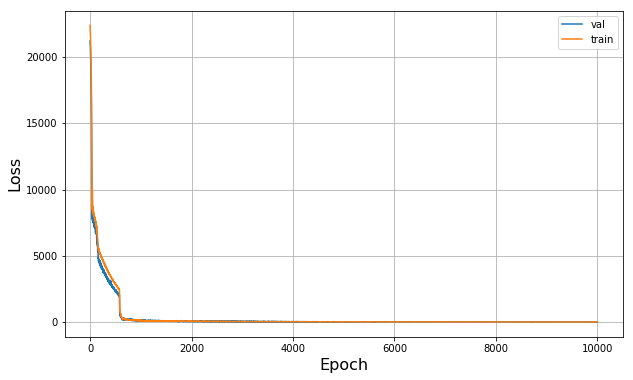

In [93]:
fig = plt.figure(figsize=(10,6))
plt.plot(vloss, label="val")
plt.plot(losses_1, label="train")
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend()
plt.grid()
fig.savefig("cnn_loss_unbranch.pdf", bbox_inches="tight")

In [94]:
# torch.save(cnn_1, 'models/cnn_models/loc_cnn_new.pt') #Saving the autoencoder model

In [95]:
#torch.cuda.set_device(0)

class LocatorCNN_XY(nn.Module):
    def __init__(self, dilate=1):
        super(LocatorCNN_XY, self).__init__()
        self.conv_layer1 = nn.Conv2d(1, 16, kernel_size=5, stride=1)
        self.conv_layer2 = nn.Conv2d(16, 32, kernel_size=5, stride=1, dilation=dilate)

        self.conv_layer3 = nn.Conv2d(32, 64, kernel_size=3, stride=1)
        self.conv_layer4 = nn.Conv2d(64, 128, kernel_size=3, stride=1)
        self.conv_layer6 = nn.Conv2d(128, 256, kernel_size=3, stride=1, dilation=dilate)
    
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        
        self.drop2 = nn.Dropout2d(p=0.1)
        self.drop1 = nn.Dropout(p=0.05)
        
        self.activation_layer_2d = nn.Tanh()
        self.activation_layer = nn.ELU()
                
        self.linear_1 = nn.Linear(2304, 1024) #Without dilation
        
        self.linear_2_x = nn.Linear(1024, 512)
        self.linear_3_x = nn.Linear(512, 128)
        self.linear_4_x = nn.Linear(128, 32)
        self.linear_5_x = nn.Linear(33, 8)
        self.linear_6_x = nn.Linear(8, 1)
        
        self.linear_2_y = nn.Linear(1024, 512)
        self.linear_3_y = nn.Linear(512, 128)
        self.linear_4_y = nn.Linear(128, 32)
        self.linear_5_y = nn.Linear(33, 8)
        self.linear_6_y = nn.Linear(8, 1)
    
    def forward(self, x, dim, channel):

        out = self.conv_layer1(x)
        out = self.activation_layer_2d(out)
        #print(out.shape)
        out = self.conv_layer2(out)
        #print(out.shape)
        out = self.activation_layer_2d(out)
        out = self.maxpool(out)
        out = self.drop2(out)
        #print(out.shape)
        
        out = self.conv_layer3(out)
        out = self.activation_layer_2d(out)
        #print(out.shape)
        out = self.conv_layer4(out)
        out = self.activation_layer_2d(out)
        out = self.maxpool(out)
        out = self.drop2(out)
        #print(out.shape)
        
        out = self.conv_layer6(out)
        out = self.activation_layer_2d(out)
        out = self.maxpool(out)
        #out = self.drop2(out)
        #print(out.shape)
        
        out = out.view(dim, -1)
        
        out = self.linear_1(out)
        out = self.activation_layer(out)
        
        out_x = self.linear_2_x(out)
        out_x = self.activation_layer(out_x)
        out_x = self.drop1(out_x)
        out_x = self.linear_3_x(out_x)
        out_x = self.activation_layer(out_x)
        out_x = self.linear_4_x(out_x)
        out_x = self.activation_layer(out_x)
        out_x = torch.cat((out_x, channel), dim=1)
        out_x = self.linear_5_x(out_x)
        out_x = self.activation_layer(out_x)
        out_x = self.linear_6_x(out_x)
        
        out_y = self.linear_2_y(out)
        out_y = self.activation_layer(out_y)
        out_y = self.drop1(out_y)
        out_y = self.linear_3_y(out_y)
        out_y = self.activation_layer(out_y)
        out_y = self.linear_4_y(out_y)
        out_y = self.activation_layer(out_y)
        out_y = torch.cat((out_y, channel), dim=1)
        out_y = self.linear_5_y(out_y)
        out_y = self.activation_layer(out_y)
        out_y = self.linear_6_y(out_y)
        
        final = torch.cat((out_x, out_y)).view(dim, -1)
        
        return final

In [96]:
import random
random.seed(0)

def train_cnn_branch(model, times_ch_tr, times_ch_v, images, location, criterion, optimizer, epoch_range,  batch_size):
    losses = []
    val_losses = []
    for num_epoch in range(epoch_range):
        selected = random.sample(range(0, len(times_ch_tr)), batch_size)
        x = np.zeros((batch_size, 54, 54))
        ch = np.zeros((batch_size, 1))
        loc = np.zeros((batch_size, 2))
        for i in range(len(selected)):
            pointer = times_ch_tr[i]
            x[i, :, :] = images[pointer]
            dim = x.shape[0]
            ch[i, :] = np.array(pointer[1])
            loc[i, :] = np.array(location[pointer])
        x = torch.from_numpy(x).float().cuda()
        x = x.view(batch_size, -1, 54, 54)
        ch = torch.from_numpy(ch).float().cuda()
        #---------FORWARD------------#
        out = model.forward(x, dim, ch)
        out = torch.tensor(out).float().cuda()
        loc = torch.from_numpy(loc).float().cuda()
        loss1 = criterion(out[0], loc[0])
        loss2 = criterion(out[1], loc[1])
        #---------BACKWARD------------#
        optimizer.zero_grad()
        (loss1 + loss2).backward()
        optimizer.step()
        
        v = random.sample(range(0, len(times_ch_v)), 30)
        v_im = np.zeros((30, 54, 54))
        v_ch = np.zeros((30, 1))
        v_loc = np.zeros((30, 2))
        for i in range(len(v)):
            pointer = times_ch_v[i]
            v_im[i, :, :] = images[pointer]
            dim = v_im.shape[0]
            v_ch[i, :] = np.array(pointer[1])
            v_loc[i, :] = np.array(location[pointer])
        
        v_im = torch.from_numpy(v_im).float().cuda()
        v_im = v_im.view(30, -1, 54, 54)
        v_ch = torch.from_numpy(v_ch).float().cuda()
        v_loc = torch.from_numpy(v_loc).float().cuda()
        
        
        val_out = model.forward(v_im, 30, v_ch)
        v_loss1 = criterion(val_out[0], v_loc[0])
        v_loss2 = criterion(val_out[1], v_loc[1])

        
        val_losses.append(v_loss1.data[0]+v_loss2.data[0])            
        losses.append(loss1.data[0]+loss2.data[0])
        print('epoch [{}/{}], loss:{:.5f}, val:{:.5f}'.format(num_epoch + 1, epoch_range, 
                                                              loss1.data[0]+loss2.data[0], v_loss1.data[0]+v_loss2.data[0]))
    return out, losses, val_losses

In [100]:
epoch_range = 10000
batch_size = 300
learning_rate = 0.0001

cnn_1 = LocatorCNN_XY().cuda()
cnn_1.apply(init_weights)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    cnn_1.parameters(), lr=learning_rate, weight_decay=0.001)

out, losses_1, vloss = train_cnn_branch(cnn_1, list_times_ch_train, list_times_ch_val ,image_data, new_location, criterion, optimizer, epoch_range, batch_size)

epoch [1/10000], loss:65352.51953, val:31532.42969
epoch [2/10000], loss:65133.41406, val:31413.92188
epoch [3/10000], loss:64913.27344, val:31337.66211
epoch [4/10000], loss:64667.92578, val:31231.73828
epoch [5/10000], loss:64473.78125, val:31133.36328
epoch [6/10000], loss:64363.28125, val:31058.03711
epoch [7/10000], loss:64268.79688, val:31000.77930
epoch [8/10000], loss:64239.67578, val:30977.33984
epoch [9/10000], loss:64205.06250, val:30963.46680
epoch [10/10000], loss:64191.97656, val:30953.57422
epoch [11/10000], loss:64184.45312, val:30950.53906
epoch [12/10000], loss:64180.76172, val:30949.10938
epoch [13/10000], loss:64180.03125, val:30936.42578
epoch [14/10000], loss:64178.33594, val:30922.34375
epoch [15/10000], loss:64177.88281, val:30921.79297
epoch [16/10000], loss:64176.39062, val:30929.60352
epoch [17/10000], loss:64175.28906, val:30923.75391
epoch [18/10000], loss:64174.07812, val:30912.68164
epoch [19/10000], loss:64174.11328, val:30891.71875
epoch [20/10000], los

epoch [159/10000], loss:20438.99609, val:15882.33203
epoch [160/10000], loss:19989.04297, val:16526.00977
epoch [161/10000], loss:19934.41602, val:15254.25293
epoch [162/10000], loss:19394.45703, val:16288.18555
epoch [163/10000], loss:18872.70703, val:16147.35938
epoch [164/10000], loss:19770.73828, val:16041.05273
epoch [165/10000], loss:19643.31836, val:15332.46289
epoch [166/10000], loss:20008.85547, val:16240.94434
epoch [167/10000], loss:19732.59375, val:15924.01270
epoch [168/10000], loss:19904.98047, val:16072.01855
epoch [169/10000], loss:19248.64648, val:16272.47754
epoch [170/10000], loss:20115.66406, val:16295.64258
epoch [171/10000], loss:19977.69141, val:16224.24414
epoch [172/10000], loss:18968.72070, val:16270.47070
epoch [173/10000], loss:19998.52539, val:16583.84375
epoch [174/10000], loss:19789.83594, val:16512.86133
epoch [175/10000], loss:20062.72266, val:16098.67969
epoch [176/10000], loss:20153.81445, val:16740.93555
epoch [177/10000], loss:20294.98633, val:16494

epoch [315/10000], loss:19416.69336, val:15557.25977
epoch [316/10000], loss:18966.89453, val:15878.18945
epoch [317/10000], loss:19540.89453, val:14830.20703
epoch [318/10000], loss:19678.82227, val:15672.39941
epoch [319/10000], loss:19605.48047, val:14925.30078
epoch [320/10000], loss:20136.92969, val:15783.10742
epoch [321/10000], loss:19216.41016, val:16687.58594
epoch [322/10000], loss:19603.22461, val:14192.73047
epoch [323/10000], loss:18615.38867, val:15471.40234
epoch [324/10000], loss:19702.33984, val:15271.53125
epoch [325/10000], loss:19292.53320, val:14841.54199
epoch [326/10000], loss:20351.37891, val:16658.26953
epoch [327/10000], loss:20272.73633, val:15980.13477
epoch [328/10000], loss:18472.71094, val:15736.37207
epoch [329/10000], loss:19223.50781, val:16270.65137
epoch [330/10000], loss:19417.79297, val:15831.58398
epoch [331/10000], loss:19664.25000, val:16086.23145
epoch [332/10000], loss:19946.20703, val:16554.29102
epoch [333/10000], loss:20163.65625, val:16607

epoch [471/10000], loss:18677.25977, val:15449.41016
epoch [472/10000], loss:18917.05078, val:15648.56641
epoch [473/10000], loss:19844.44141, val:16331.68164
epoch [474/10000], loss:19529.14648, val:15263.31641
epoch [475/10000], loss:19674.78125, val:15925.55762
epoch [476/10000], loss:20321.43945, val:16605.65234
epoch [477/10000], loss:19977.82422, val:15557.97070
epoch [478/10000], loss:20761.80078, val:15834.85156
epoch [479/10000], loss:20100.68359, val:16146.93359
epoch [480/10000], loss:19669.24609, val:15786.99512
epoch [481/10000], loss:21254.14844, val:16132.13672
epoch [482/10000], loss:20169.24805, val:15981.76465
epoch [483/10000], loss:20051.16992, val:15838.11816
epoch [484/10000], loss:20225.32031, val:16352.35449
epoch [485/10000], loss:19215.46484, val:15877.50781
epoch [486/10000], loss:20239.67188, val:17439.42383
epoch [487/10000], loss:19775.91406, val:16555.86719
epoch [488/10000], loss:19248.00586, val:14292.69531
epoch [489/10000], loss:19104.71875, val:16185

epoch [627/10000], loss:19489.80859, val:15512.81348
epoch [628/10000], loss:20227.62109, val:16047.74023
epoch [629/10000], loss:18694.91406, val:15708.92969
epoch [630/10000], loss:20122.43750, val:17351.68164
epoch [631/10000], loss:19106.16016, val:17069.92969
epoch [632/10000], loss:18719.94727, val:16283.04883
epoch [633/10000], loss:19241.22070, val:17164.97656
epoch [634/10000], loss:20193.39844, val:15630.08496
epoch [635/10000], loss:20135.05859, val:16631.21484
epoch [636/10000], loss:19939.93359, val:15993.32812
epoch [637/10000], loss:19382.03320, val:17510.53125
epoch [638/10000], loss:20067.33203, val:16558.08984
epoch [639/10000], loss:18509.08203, val:14565.65527
epoch [640/10000], loss:19482.93359, val:16595.98047
epoch [641/10000], loss:18830.10547, val:16558.59570
epoch [642/10000], loss:19928.76953, val:16692.89453
epoch [643/10000], loss:20211.56641, val:16154.73926
epoch [644/10000], loss:21423.70703, val:15938.48047
epoch [645/10000], loss:19390.20508, val:15004

epoch [783/10000], loss:19897.35547, val:16687.43164
epoch [784/10000], loss:20123.15234, val:16774.94531
epoch [785/10000], loss:19340.66602, val:15077.83105
epoch [786/10000], loss:20465.95703, val:14786.41602
epoch [787/10000], loss:19685.30859, val:16954.41016
epoch [788/10000], loss:19974.44141, val:16545.26172
epoch [789/10000], loss:19641.74609, val:16814.94727
epoch [790/10000], loss:19451.88086, val:15838.09180
epoch [791/10000], loss:19299.55859, val:15716.05273
epoch [792/10000], loss:19337.57812, val:15170.75977
epoch [793/10000], loss:19521.14648, val:14962.09668
epoch [794/10000], loss:20495.10156, val:15324.31250
epoch [795/10000], loss:20608.30859, val:15349.66016
epoch [796/10000], loss:19254.71875, val:16418.17578
epoch [797/10000], loss:18927.25391, val:15368.85254
epoch [798/10000], loss:19726.60742, val:17135.15234
epoch [799/10000], loss:19026.39062, val:16848.81250
epoch [800/10000], loss:20126.93164, val:16627.62500
epoch [801/10000], loss:18889.21484, val:16413

epoch [939/10000], loss:19398.39648, val:16887.31250
epoch [940/10000], loss:20622.64844, val:16694.89258
epoch [941/10000], loss:19022.37695, val:14579.86426
epoch [942/10000], loss:19229.01953, val:15978.70605
epoch [943/10000], loss:20085.50000, val:15948.61914
epoch [944/10000], loss:19719.21094, val:14288.39844
epoch [945/10000], loss:19707.66406, val:16926.53711
epoch [946/10000], loss:20209.62500, val:16357.68750
epoch [947/10000], loss:19201.08789, val:16093.78613
epoch [948/10000], loss:19837.21875, val:17115.28125
epoch [949/10000], loss:20098.51367, val:15989.33301
epoch [950/10000], loss:19472.29883, val:16770.23438
epoch [951/10000], loss:20278.63281, val:16758.93359
epoch [952/10000], loss:19689.96875, val:16736.72070
epoch [953/10000], loss:19164.33984, val:17671.77344
epoch [954/10000], loss:20119.95312, val:17247.00391
epoch [955/10000], loss:18664.29883, val:15538.46387
epoch [956/10000], loss:19261.61719, val:15933.29883
epoch [957/10000], loss:19761.23633, val:16592

epoch [1093/10000], loss:20200.06836, val:16076.69434
epoch [1094/10000], loss:19894.47656, val:15092.03906
epoch [1095/10000], loss:19429.36133, val:16905.33984
epoch [1096/10000], loss:19637.38086, val:14881.84473
epoch [1097/10000], loss:20154.75195, val:16805.10156
epoch [1098/10000], loss:17845.51367, val:16828.56445
epoch [1099/10000], loss:19200.94531, val:16855.87891
epoch [1100/10000], loss:19548.90625, val:16225.86914
epoch [1101/10000], loss:19237.18945, val:16881.06641
epoch [1102/10000], loss:19254.18750, val:16876.64648
epoch [1103/10000], loss:20695.40430, val:16362.67578
epoch [1104/10000], loss:19806.94531, val:17845.26953
epoch [1105/10000], loss:18965.14648, val:17184.41602
epoch [1106/10000], loss:20332.98242, val:17550.21875
epoch [1107/10000], loss:18879.57422, val:16367.46094
epoch [1108/10000], loss:19085.71289, val:15800.08887
epoch [1109/10000], loss:19286.02539, val:17140.21289
epoch [1110/10000], loss:20244.44531, val:16699.70703
epoch [1111/10000], loss:186

epoch [1245/10000], loss:19567.99414, val:16636.32031
epoch [1246/10000], loss:20318.83398, val:16369.57422
epoch [1247/10000], loss:18821.17969, val:16337.27148
epoch [1248/10000], loss:19481.33984, val:15660.23047
epoch [1249/10000], loss:20286.14453, val:16036.38574
epoch [1250/10000], loss:19659.32812, val:16574.19531
epoch [1251/10000], loss:20151.36914, val:15710.78711
epoch [1252/10000], loss:18630.89453, val:16777.19531
epoch [1253/10000], loss:18789.46875, val:16975.91797
epoch [1254/10000], loss:20310.09766, val:16329.00195
epoch [1255/10000], loss:19253.15234, val:16903.41016
epoch [1256/10000], loss:19018.21094, val:16828.10352
epoch [1257/10000], loss:20042.27148, val:15970.48633
epoch [1258/10000], loss:18524.58398, val:16681.61328
epoch [1259/10000], loss:18819.28516, val:14567.01270
epoch [1260/10000], loss:19582.30859, val:17378.53906
epoch [1261/10000], loss:19746.68359, val:17272.61328
epoch [1262/10000], loss:18032.28711, val:16391.44336
epoch [1263/10000], loss:196

epoch [1397/10000], loss:18996.07031, val:15554.29785
epoch [1398/10000], loss:18126.00195, val:15678.97266
epoch [1399/10000], loss:19073.74219, val:17327.78516
epoch [1400/10000], loss:19860.50000, val:15961.88086
epoch [1401/10000], loss:18770.42188, val:16359.82617
epoch [1402/10000], loss:18159.23828, val:18395.91211
epoch [1403/10000], loss:19875.43555, val:18379.00000
epoch [1404/10000], loss:19896.85938, val:17339.05078
epoch [1405/10000], loss:19466.79688, val:16513.97656
epoch [1406/10000], loss:20418.85156, val:16456.23438
epoch [1407/10000], loss:19860.08398, val:17135.79297
epoch [1408/10000], loss:20381.58594, val:17097.73633
epoch [1409/10000], loss:18724.66797, val:16575.44727
epoch [1410/10000], loss:19587.63281, val:16363.33984
epoch [1411/10000], loss:20763.34766, val:16039.54492
epoch [1412/10000], loss:20298.51953, val:16728.78320
epoch [1413/10000], loss:18646.58203, val:16477.96484
epoch [1414/10000], loss:20472.10547, val:15082.07227
epoch [1415/10000], loss:203

epoch [1549/10000], loss:19651.32812, val:15815.55664
epoch [1550/10000], loss:19459.35352, val:16132.70508
epoch [1551/10000], loss:18374.62500, val:16729.65234
epoch [1552/10000], loss:20015.73828, val:17101.45898
epoch [1553/10000], loss:19811.85938, val:16471.68359
epoch [1554/10000], loss:20381.69922, val:15195.18555
epoch [1555/10000], loss:20017.71484, val:16743.35156
epoch [1556/10000], loss:19326.42383, val:16742.00781
epoch [1557/10000], loss:19795.93750, val:16124.67188
epoch [1558/10000], loss:20426.29492, val:15728.72852
epoch [1559/10000], loss:18762.67969, val:16970.99805
epoch [1560/10000], loss:20990.45117, val:16095.05664
epoch [1561/10000], loss:20405.41406, val:16279.34180
epoch [1562/10000], loss:19125.73047, val:15098.28223
epoch [1563/10000], loss:20104.61328, val:14995.36621
epoch [1564/10000], loss:18843.02344, val:15411.51953
epoch [1565/10000], loss:19078.48828, val:16431.95508
epoch [1566/10000], loss:18706.03320, val:15483.73828
epoch [1567/10000], loss:203

epoch [1701/10000], loss:19945.06641, val:16250.44141
epoch [1702/10000], loss:19399.48828, val:16864.39453
epoch [1703/10000], loss:18389.84375, val:15334.65820
epoch [1704/10000], loss:18722.49805, val:17078.03320
epoch [1705/10000], loss:19572.52344, val:16993.28906
epoch [1706/10000], loss:20866.21680, val:15952.02051
epoch [1707/10000], loss:18525.76758, val:17009.01172
epoch [1708/10000], loss:20140.09180, val:16265.71094
epoch [1709/10000], loss:20764.46875, val:16091.03906
epoch [1710/10000], loss:19978.88477, val:16411.08789
epoch [1711/10000], loss:19032.17969, val:16342.79688
epoch [1712/10000], loss:18617.83984, val:16350.53418
epoch [1713/10000], loss:18100.67969, val:14813.07422
epoch [1714/10000], loss:18946.64453, val:17961.01953
epoch [1715/10000], loss:20543.47461, val:15957.70801
epoch [1716/10000], loss:19813.87500, val:15359.68359
epoch [1717/10000], loss:19968.94922, val:16875.75586
epoch [1718/10000], loss:20078.89062, val:16522.42969
epoch [1719/10000], loss:196

epoch [1853/10000], loss:19570.53906, val:16784.79688
epoch [1854/10000], loss:18814.99414, val:17159.84766
epoch [1855/10000], loss:20258.72266, val:16841.87109
epoch [1856/10000], loss:18822.68945, val:17912.08789
epoch [1857/10000], loss:20890.56055, val:17776.44336
epoch [1858/10000], loss:20273.56055, val:17484.11523
epoch [1859/10000], loss:19086.68555, val:16531.79688
epoch [1860/10000], loss:19756.83984, val:17044.21094
epoch [1861/10000], loss:20257.36328, val:17246.96875
epoch [1862/10000], loss:18678.75195, val:17035.06055
epoch [1863/10000], loss:19094.88086, val:16892.06250
epoch [1864/10000], loss:19000.22266, val:15692.00195
epoch [1865/10000], loss:18527.25781, val:16692.54102
epoch [1866/10000], loss:19738.50000, val:15277.82812
epoch [1867/10000], loss:19270.03711, val:15551.08984
epoch [1868/10000], loss:19473.45117, val:15617.26074
epoch [1869/10000], loss:21277.85156, val:16504.05078
epoch [1870/10000], loss:19739.92578, val:16203.64062
epoch [1871/10000], loss:199

epoch [2005/10000], loss:20001.39844, val:17117.33398
epoch [2006/10000], loss:19467.67188, val:15335.71680
epoch [2007/10000], loss:19086.92188, val:16086.51367
epoch [2008/10000], loss:19392.87500, val:17059.01172
epoch [2009/10000], loss:19290.58594, val:16227.71973
epoch [2010/10000], loss:21912.56836, val:16612.27344
epoch [2011/10000], loss:18622.34375, val:16856.99414
epoch [2012/10000], loss:20762.34766, val:16742.29883
epoch [2013/10000], loss:19067.42578, val:15695.68750
epoch [2014/10000], loss:18751.13477, val:14984.59961
epoch [2015/10000], loss:18972.62891, val:17390.83008
epoch [2016/10000], loss:18599.51367, val:17596.99609
epoch [2017/10000], loss:20419.63281, val:16397.25195
epoch [2018/10000], loss:19108.64453, val:16776.70703
epoch [2019/10000], loss:21329.61914, val:17294.65234
epoch [2020/10000], loss:18970.19531, val:15619.04590
epoch [2021/10000], loss:18907.13086, val:16901.06250
epoch [2022/10000], loss:19887.43750, val:16733.95703
epoch [2023/10000], loss:175

epoch [2157/10000], loss:19684.54688, val:16367.63672
epoch [2158/10000], loss:21514.04688, val:17021.10352
epoch [2159/10000], loss:19364.92578, val:17500.98438
epoch [2160/10000], loss:20070.44531, val:16575.22266
epoch [2161/10000], loss:18027.88281, val:16805.64844
epoch [2162/10000], loss:19787.81250, val:17451.91602
epoch [2163/10000], loss:20916.47656, val:16405.39258
epoch [2164/10000], loss:17893.87500, val:17130.96289
epoch [2165/10000], loss:19497.88672, val:16581.67578
epoch [2166/10000], loss:18192.07227, val:16461.49023
epoch [2167/10000], loss:18115.78906, val:16051.75977
epoch [2168/10000], loss:18895.80078, val:15975.76172
epoch [2169/10000], loss:20711.25977, val:16417.31641
epoch [2170/10000], loss:18683.73438, val:15522.36523
epoch [2171/10000], loss:18663.48047, val:16592.78125
epoch [2172/10000], loss:19118.79688, val:16859.96094
epoch [2173/10000], loss:19288.25391, val:17801.13281
epoch [2174/10000], loss:20904.90039, val:17014.35547
epoch [2175/10000], loss:191

epoch [2309/10000], loss:15776.68164, val:27947.26172
epoch [2310/10000], loss:15450.68164, val:29274.13086
epoch [2311/10000], loss:16155.69434, val:29020.43359
epoch [2312/10000], loss:13958.16602, val:32507.78906
epoch [2313/10000], loss:13509.63086, val:31156.66406
epoch [2314/10000], loss:14405.11816, val:27479.68750
epoch [2315/10000], loss:13337.90430, val:31104.73047
epoch [2316/10000], loss:13823.43848, val:38334.60938
epoch [2317/10000], loss:13435.16016, val:36893.66406
epoch [2318/10000], loss:14305.32812, val:40775.63672
epoch [2319/10000], loss:14313.81836, val:42123.12891
epoch [2320/10000], loss:12479.53516, val:40391.83594
epoch [2321/10000], loss:11509.75977, val:36584.42969
epoch [2322/10000], loss:14239.94727, val:37606.57031
epoch [2323/10000], loss:11531.08203, val:35702.71094
epoch [2324/10000], loss:11174.90527, val:34347.25781
epoch [2325/10000], loss:10998.97949, val:44900.14844
epoch [2326/10000], loss:12076.23242, val:41747.07031
epoch [2327/10000], loss:145

epoch [2467/10000], loss:73.69387, val:94259.54688
epoch [2468/10000], loss:25.38472, val:107586.82812
epoch [2469/10000], loss:109.42700, val:94549.31250
epoch [2470/10000], loss:154.02994, val:107983.96875
epoch [2471/10000], loss:46.17653, val:102031.50000
epoch [2472/10000], loss:27.56075, val:96282.08594
epoch [2473/10000], loss:34.69785, val:86664.78125
epoch [2474/10000], loss:169.17555, val:93209.92969
epoch [2475/10000], loss:95.59155, val:87056.35938
epoch [2476/10000], loss:93.70813, val:92210.51562
epoch [2477/10000], loss:46.64528, val:97598.25000
epoch [2478/10000], loss:60.98215, val:98801.82812
epoch [2479/10000], loss:37.65344, val:95929.64844
epoch [2480/10000], loss:24.52826, val:96653.23438
epoch [2481/10000], loss:74.47065, val:89659.92188
epoch [2482/10000], loss:58.61100, val:94730.69531
epoch [2483/10000], loss:94.04927, val:97094.53125
epoch [2484/10000], loss:34.80400, val:95585.00781
epoch [2485/10000], loss:36.17883, val:99251.29688
epoch [2486/10000], loss:

epoch [2627/10000], loss:88.33881, val:89947.76562
epoch [2628/10000], loss:91.49190, val:99495.03125
epoch [2629/10000], loss:32.80148, val:93832.21094
epoch [2630/10000], loss:125.99711, val:99403.03125
epoch [2631/10000], loss:7.96851, val:95041.60938
epoch [2632/10000], loss:54.08583, val:98114.56250
epoch [2633/10000], loss:27.05893, val:93356.51562
epoch [2634/10000], loss:56.24337, val:96942.00000
epoch [2635/10000], loss:19.23996, val:99421.54688
epoch [2636/10000], loss:27.32663, val:96460.53125
epoch [2637/10000], loss:96.97912, val:94654.26562
epoch [2638/10000], loss:85.91878, val:94038.81250
epoch [2639/10000], loss:12.95242, val:97318.98438
epoch [2640/10000], loss:97.12277, val:96269.89062
epoch [2641/10000], loss:8.82257, val:97571.82812
epoch [2642/10000], loss:55.79731, val:87467.96875
epoch [2643/10000], loss:42.40094, val:90021.76562
epoch [2644/10000], loss:46.35384, val:91353.64062
epoch [2645/10000], loss:19.96183, val:94306.80469
epoch [2646/10000], loss:18.4198

epoch [2787/10000], loss:102.59512, val:95489.24219
epoch [2788/10000], loss:90.15195, val:91858.07812
epoch [2789/10000], loss:77.38310, val:94154.40625
epoch [2790/10000], loss:54.70317, val:94600.57812
epoch [2791/10000], loss:68.40015, val:99704.34375
epoch [2792/10000], loss:86.46231, val:96636.12500
epoch [2793/10000], loss:41.80671, val:92762.22656
epoch [2794/10000], loss:24.56199, val:93959.88281
epoch [2795/10000], loss:86.98101, val:98625.67188
epoch [2796/10000], loss:136.12296, val:97358.03125
epoch [2797/10000], loss:34.22185, val:90816.25000
epoch [2798/10000], loss:55.25533, val:90924.17188
epoch [2799/10000], loss:95.11230, val:88388.06250
epoch [2800/10000], loss:8.31078, val:93980.99219
epoch [2801/10000], loss:11.93633, val:89226.89062
epoch [2802/10000], loss:34.87717, val:95553.81250
epoch [2803/10000], loss:63.14188, val:89861.40625
epoch [2804/10000], loss:13.89563, val:91655.38281
epoch [2805/10000], loss:38.30421, val:95826.07031
epoch [2806/10000], loss:26.61

epoch [2949/10000], loss:77.16856, val:93238.53125
epoch [2950/10000], loss:68.42683, val:99795.92188
epoch [2951/10000], loss:55.64665, val:91549.04688
epoch [2952/10000], loss:83.72088, val:90714.63281
epoch [2953/10000], loss:14.05019, val:91309.12500
epoch [2954/10000], loss:18.51423, val:91488.10938
epoch [2955/10000], loss:77.75929, val:93448.26562
epoch [2956/10000], loss:71.24595, val:103089.60156
epoch [2957/10000], loss:35.87916, val:87113.23438
epoch [2958/10000], loss:116.08801, val:99947.60156
epoch [2959/10000], loss:33.75082, val:94708.68750
epoch [2960/10000], loss:46.70562, val:93997.16406
epoch [2961/10000], loss:69.40656, val:87634.60938
epoch [2962/10000], loss:21.24300, val:85270.81250
epoch [2963/10000], loss:15.75638, val:85829.95312
epoch [2964/10000], loss:99.48598, val:86319.02344
epoch [2965/10000], loss:45.32881, val:92468.38281
epoch [2966/10000], loss:229.16696, val:100824.31250
epoch [2967/10000], loss:7.79229, val:98299.57031
epoch [2968/10000], loss:30.

epoch [3111/10000], loss:74.61072, val:84529.32812
epoch [3112/10000], loss:84.85548, val:98133.81250
epoch [3113/10000], loss:80.50452, val:100285.17188
epoch [3114/10000], loss:31.28319, val:89707.64062
epoch [3115/10000], loss:60.83217, val:94197.27344
epoch [3116/10000], loss:46.98788, val:94093.93750
epoch [3117/10000], loss:97.08666, val:98364.71875
epoch [3118/10000], loss:13.66680, val:98598.05469
epoch [3119/10000], loss:9.28307, val:94918.28125
epoch [3120/10000], loss:48.05743, val:89796.43750
epoch [3121/10000], loss:10.79419, val:91691.92188
epoch [3122/10000], loss:35.41880, val:91130.37500
epoch [3123/10000], loss:45.73594, val:99035.57812
epoch [3124/10000], loss:35.42622, val:96518.10156
epoch [3125/10000], loss:49.56093, val:90764.70312
epoch [3126/10000], loss:63.83402, val:85518.32812
epoch [3127/10000], loss:16.29582, val:92765.78906
epoch [3128/10000], loss:19.15403, val:93388.39062
epoch [3129/10000], loss:10.43428, val:88337.18750
epoch [3130/10000], loss:2.0527

epoch [3273/10000], loss:25.61617, val:98860.12500
epoch [3274/10000], loss:30.01190, val:88741.71094
epoch [3275/10000], loss:17.97296, val:93368.96875
epoch [3276/10000], loss:67.85693, val:89179.43750
epoch [3277/10000], loss:45.02269, val:87714.07812
epoch [3278/10000], loss:75.83858, val:97783.32812
epoch [3279/10000], loss:40.23758, val:92161.12500
epoch [3280/10000], loss:61.81139, val:88559.12500
epoch [3281/10000], loss:264.08344, val:89810.56250
epoch [3282/10000], loss:8.06918, val:98561.53906
epoch [3283/10000], loss:37.77329, val:94751.15625
epoch [3284/10000], loss:45.25103, val:93092.25000
epoch [3285/10000], loss:48.08541, val:96750.55469
epoch [3286/10000], loss:49.56690, val:97041.84375
epoch [3287/10000], loss:2.78475, val:93964.57812
epoch [3288/10000], loss:6.58525, val:92525.54688
epoch [3289/10000], loss:21.16888, val:95645.57812
epoch [3290/10000], loss:50.19333, val:97201.36719
epoch [3291/10000], loss:51.33439, val:98690.79688
epoch [3292/10000], loss:68.43018

epoch [3435/10000], loss:28.91104, val:91384.60156
epoch [3436/10000], loss:36.99506, val:91768.74219
epoch [3437/10000], loss:31.86021, val:98403.03906
epoch [3438/10000], loss:71.80973, val:88020.44531
epoch [3439/10000], loss:19.43589, val:87386.50000
epoch [3440/10000], loss:131.34258, val:94773.40625
epoch [3441/10000], loss:71.36309, val:90017.64062
epoch [3442/10000], loss:76.84991, val:91519.14062
epoch [3443/10000], loss:59.87720, val:101085.63281
epoch [3444/10000], loss:39.48555, val:99458.12500
epoch [3445/10000], loss:19.12206, val:95067.47656
epoch [3446/10000], loss:16.48886, val:93659.24219
epoch [3447/10000], loss:46.69743, val:89608.45312
epoch [3448/10000], loss:88.78387, val:92812.25781
epoch [3449/10000], loss:67.08035, val:86269.51562
epoch [3450/10000], loss:167.74719, val:89815.56250
epoch [3451/10000], loss:210.96725, val:92160.25000
epoch [3452/10000], loss:13.21709, val:97477.28125
epoch [3453/10000], loss:61.76338, val:88883.42188
epoch [3454/10000], loss:19

epoch [3597/10000], loss:23.75859, val:85346.23438
epoch [3598/10000], loss:32.20663, val:93794.68750
epoch [3599/10000], loss:22.29384, val:90259.35938
epoch [3600/10000], loss:43.46394, val:86201.64062
epoch [3601/10000], loss:74.14494, val:91075.81250
epoch [3602/10000], loss:43.91122, val:90613.51562
epoch [3603/10000], loss:57.23244, val:84462.60938
epoch [3604/10000], loss:55.30104, val:93266.12500
epoch [3605/10000], loss:65.09014, val:89701.82031
epoch [3606/10000], loss:32.40207, val:92283.24219
epoch [3607/10000], loss:16.02835, val:87526.89062
epoch [3608/10000], loss:26.53698, val:87556.78125
epoch [3609/10000], loss:20.51931, val:90326.80469
epoch [3610/10000], loss:40.58584, val:89742.07031
epoch [3611/10000], loss:32.53113, val:95452.76562
epoch [3612/10000], loss:45.01415, val:96508.39062
epoch [3613/10000], loss:92.48554, val:84306.42188
epoch [3614/10000], loss:70.92716, val:84873.30469
epoch [3615/10000], loss:12.19874, val:92185.83594
epoch [3616/10000], loss:78.389

epoch [3759/10000], loss:62.83780, val:95419.32812
epoch [3760/10000], loss:36.97591, val:85437.51562
epoch [3761/10000], loss:39.93081, val:88474.52344
epoch [3762/10000], loss:26.20174, val:86375.92969
epoch [3763/10000], loss:18.70271, val:87061.07031
epoch [3764/10000], loss:38.74063, val:93295.90625
epoch [3765/10000], loss:25.31073, val:94417.69531
epoch [3766/10000], loss:22.66016, val:92621.87500
epoch [3767/10000], loss:33.00197, val:89422.88281
epoch [3768/10000], loss:21.85550, val:91233.76562
epoch [3769/10000], loss:8.27509, val:92764.01562
epoch [3770/10000], loss:15.30364, val:90923.10938
epoch [3771/10000], loss:55.31358, val:90830.07031
epoch [3772/10000], loss:16.96946, val:92152.82031
epoch [3773/10000], loss:52.67738, val:92641.10938
epoch [3774/10000], loss:47.82807, val:95735.11719
epoch [3775/10000], loss:19.13921, val:90416.70312
epoch [3776/10000], loss:19.82682, val:93433.40625
epoch [3777/10000], loss:74.83966, val:90841.02344
epoch [3778/10000], loss:17.8218

epoch [3921/10000], loss:27.25960, val:83662.17188
epoch [3922/10000], loss:24.72408, val:94361.39062
epoch [3923/10000], loss:23.30995, val:98594.92188
epoch [3924/10000], loss:31.85753, val:96782.29688
epoch [3925/10000], loss:38.85393, val:96311.28125
epoch [3926/10000], loss:37.73494, val:89546.64062
epoch [3927/10000], loss:47.96113, val:91796.94531
epoch [3928/10000], loss:32.38384, val:95787.93750
epoch [3929/10000], loss:46.40743, val:92672.14062
epoch [3930/10000], loss:25.24887, val:93667.84375
epoch [3931/10000], loss:7.43144, val:95852.73438
epoch [3932/10000], loss:6.10537, val:94778.64062
epoch [3933/10000], loss:47.45480, val:91751.68750
epoch [3934/10000], loss:44.15336, val:93920.62500
epoch [3935/10000], loss:17.29164, val:92973.43750
epoch [3936/10000], loss:41.28062, val:88917.85938
epoch [3937/10000], loss:95.36482, val:86240.48438
epoch [3938/10000], loss:8.18924, val:87223.76562
epoch [3939/10000], loss:5.10168, val:85718.29688
epoch [3940/10000], loss:83.52665, 

epoch [4083/10000], loss:26.91713, val:91911.11719
epoch [4084/10000], loss:73.72535, val:90345.12500
epoch [4085/10000], loss:42.84708, val:93961.39844
epoch [4086/10000], loss:17.22257, val:87165.67969
epoch [4087/10000], loss:2.77015, val:91736.31250
epoch [4088/10000], loss:33.98464, val:88027.87500
epoch [4089/10000], loss:16.42711, val:87013.70312
epoch [4090/10000], loss:18.96832, val:94826.83594
epoch [4091/10000], loss:61.37151, val:96206.74219
epoch [4092/10000], loss:56.49001, val:90870.10938
epoch [4093/10000], loss:98.13173, val:90738.70312
epoch [4094/10000], loss:29.38364, val:91444.16406
epoch [4095/10000], loss:11.05760, val:89350.96094
epoch [4096/10000], loss:69.84241, val:93722.98438
epoch [4097/10000], loss:22.95784, val:86771.96875
epoch [4098/10000], loss:10.16673, val:87230.37500
epoch [4099/10000], loss:26.82837, val:89181.92188
epoch [4100/10000], loss:12.12468, val:92717.28906
epoch [4101/10000], loss:41.55098, val:97213.35938
epoch [4102/10000], loss:36.7369

epoch [4245/10000], loss:33.91582, val:91288.97656
epoch [4246/10000], loss:12.20057, val:87437.92188
epoch [4247/10000], loss:28.18602, val:97634.26562
epoch [4248/10000], loss:46.75148, val:96848.75781
epoch [4249/10000], loss:24.66469, val:80596.94531
epoch [4250/10000], loss:4.67213, val:80401.00000
epoch [4251/10000], loss:27.81716, val:92057.10938
epoch [4252/10000], loss:52.61192, val:89673.82031
epoch [4253/10000], loss:12.36293, val:87210.70312
epoch [4254/10000], loss:40.65301, val:90116.82812
epoch [4255/10000], loss:15.26269, val:90601.64062
epoch [4256/10000], loss:25.51112, val:90812.63281
epoch [4257/10000], loss:52.20961, val:95136.29688
epoch [4258/10000], loss:8.06013, val:96567.71875
epoch [4259/10000], loss:15.25582, val:92839.00000
epoch [4260/10000], loss:4.05984, val:90289.37500
epoch [4261/10000], loss:20.94726, val:85860.62500
epoch [4262/10000], loss:49.12267, val:96614.25000
epoch [4263/10000], loss:40.29510, val:97231.97656
epoch [4264/10000], loss:81.30873,

epoch [4407/10000], loss:29.16546, val:98098.00000
epoch [4408/10000], loss:27.33254, val:96395.95312
epoch [4409/10000], loss:51.37317, val:101423.24219
epoch [4410/10000], loss:85.38788, val:90915.89844
epoch [4411/10000], loss:70.01276, val:89191.44531
epoch [4412/10000], loss:56.39793, val:87651.07031
epoch [4413/10000], loss:44.23553, val:87761.78906
epoch [4414/10000], loss:45.88698, val:90210.03125
epoch [4415/10000], loss:80.17340, val:89310.28906
epoch [4416/10000], loss:12.22809, val:97389.66406
epoch [4417/10000], loss:22.73888, val:89645.62500
epoch [4418/10000], loss:39.05899, val:93480.60938
epoch [4419/10000], loss:88.21560, val:92795.32031
epoch [4420/10000], loss:12.81435, val:93531.45312
epoch [4421/10000], loss:12.86491, val:94836.79688
epoch [4422/10000], loss:61.35754, val:94372.41406
epoch [4423/10000], loss:88.73379, val:98123.71875
epoch [4424/10000], loss:21.57445, val:90299.37500
epoch [4425/10000], loss:170.25647, val:99930.10938
epoch [4426/10000], loss:24.8

epoch [4569/10000], loss:49.15681, val:98710.76562
epoch [4570/10000], loss:68.93304, val:91436.09375
epoch [4571/10000], loss:37.18549, val:99939.32812
epoch [4572/10000], loss:61.83890, val:91596.34375
epoch [4573/10000], loss:77.71318, val:87302.01562
epoch [4574/10000], loss:68.71851, val:96374.06250
epoch [4575/10000], loss:30.22209, val:94607.37500
epoch [4576/10000], loss:52.20383, val:94808.80469
epoch [4577/10000], loss:33.08000, val:90545.73438
epoch [4578/10000], loss:13.92316, val:87369.32812
epoch [4579/10000], loss:4.76898, val:91135.95312
epoch [4580/10000], loss:23.06261, val:88219.28125
epoch [4581/10000], loss:19.98505, val:86856.92188
epoch [4582/10000], loss:26.39558, val:92416.93750
epoch [4583/10000], loss:76.63232, val:88620.45312
epoch [4584/10000], loss:73.47755, val:91945.34375
epoch [4585/10000], loss:9.41345, val:90499.50000
epoch [4586/10000], loss:5.77585, val:87689.85938
epoch [4587/10000], loss:57.23009, val:90694.36719
epoch [4588/10000], loss:5.78482, 

epoch [4731/10000], loss:30.91111, val:95851.82812
epoch [4732/10000], loss:10.81731, val:87565.57812
epoch [4733/10000], loss:29.54723, val:88560.79688
epoch [4734/10000], loss:5.09478, val:96396.46094
epoch [4735/10000], loss:27.27306, val:93912.68750
epoch [4736/10000], loss:32.38152, val:95640.86719
epoch [4737/10000], loss:100.49331, val:94959.71094
epoch [4738/10000], loss:17.17874, val:94679.67188
epoch [4739/10000], loss:69.68706, val:94615.56250
epoch [4740/10000], loss:14.37572, val:86502.10156
epoch [4741/10000], loss:35.07290, val:91564.64844
epoch [4742/10000], loss:30.04085, val:92330.75000
epoch [4743/10000], loss:13.24560, val:87232.08594
epoch [4744/10000], loss:10.84256, val:92479.87500
epoch [4745/10000], loss:10.66823, val:93155.76562
epoch [4746/10000], loss:9.22689, val:92121.82812
epoch [4747/10000], loss:27.21106, val:88996.62500
epoch [4748/10000], loss:39.38791, val:94071.84375
epoch [4749/10000], loss:23.75541, val:93448.75000
epoch [4750/10000], loss:20.8470

epoch [4893/10000], loss:24.19955, val:83727.94531
epoch [4894/10000], loss:67.10275, val:94066.60938
epoch [4895/10000], loss:11.23133, val:83340.82812
epoch [4896/10000], loss:42.29475, val:92328.84375
epoch [4897/10000], loss:38.48945, val:90847.23438
epoch [4898/10000], loss:89.70690, val:89993.99219
epoch [4899/10000], loss:1.61076, val:91208.18750
epoch [4900/10000], loss:17.16626, val:91259.64844
epoch [4901/10000], loss:25.02030, val:92469.50781
epoch [4902/10000], loss:60.68527, val:94908.15625
epoch [4903/10000], loss:112.79416, val:86289.91406
epoch [4904/10000], loss:37.12199, val:91593.20312
epoch [4905/10000], loss:21.45262, val:91878.00781
epoch [4906/10000], loss:59.66046, val:91340.89062
epoch [4907/10000], loss:3.96818, val:84910.34375
epoch [4908/10000], loss:67.01321, val:94739.89062
epoch [4909/10000], loss:16.90104, val:96606.76562
epoch [4910/10000], loss:8.99607, val:90839.25000
epoch [4911/10000], loss:10.10388, val:86331.95312
epoch [4912/10000], loss:7.01946,

epoch [5055/10000], loss:63.51669, val:76591.21094
epoch [5056/10000], loss:67.69962, val:86247.73438
epoch [5057/10000], loss:56.53888, val:88115.51562
epoch [5058/10000], loss:57.30280, val:89173.21094
epoch [5059/10000], loss:53.30830, val:87976.95312
epoch [5060/10000], loss:84.63800, val:89985.65625
epoch [5061/10000], loss:124.23460, val:82633.32812
epoch [5062/10000], loss:50.13404, val:84531.79688
epoch [5063/10000], loss:47.59728, val:93767.95312
epoch [5064/10000], loss:34.29227, val:84589.83594
epoch [5065/10000], loss:38.59219, val:88477.18750
epoch [5066/10000], loss:46.49797, val:84462.60938
epoch [5067/10000], loss:54.99015, val:89411.70312
epoch [5068/10000], loss:13.52189, val:88239.32031
epoch [5069/10000], loss:33.40934, val:87782.43750
epoch [5070/10000], loss:29.97006, val:85267.16406
epoch [5071/10000], loss:36.65089, val:88663.38281
epoch [5072/10000], loss:39.99216, val:85858.26562
epoch [5073/10000], loss:31.66181, val:80107.34375
epoch [5074/10000], loss:78.39

epoch [5217/10000], loss:8.53607, val:86920.95312
epoch [5218/10000], loss:9.51267, val:88608.09375
epoch [5219/10000], loss:138.36632, val:92069.76562
epoch [5220/10000], loss:21.47350, val:91105.17969
epoch [5221/10000], loss:22.03515, val:90185.15625
epoch [5222/10000], loss:32.29533, val:93463.68750
epoch [5223/10000], loss:147.65573, val:90536.34375
epoch [5224/10000], loss:116.14386, val:93724.43750
epoch [5225/10000], loss:39.59730, val:95052.71094
epoch [5226/10000], loss:77.29993, val:94021.48438
epoch [5227/10000], loss:26.35037, val:87821.51562
epoch [5228/10000], loss:37.79753, val:85639.66406
epoch [5229/10000], loss:94.90951, val:82769.25781
epoch [5230/10000], loss:107.51866, val:76693.48438
epoch [5231/10000], loss:18.50948, val:79023.47656
epoch [5232/10000], loss:36.66592, val:85381.85938
epoch [5233/10000], loss:171.15077, val:87766.96875
epoch [5234/10000], loss:49.28930, val:91766.65625
epoch [5235/10000], loss:167.74052, val:79651.23438
epoch [5236/10000], loss:99

epoch [5379/10000], loss:14.13053, val:81212.56250
epoch [5380/10000], loss:22.27433, val:81527.18750
epoch [5381/10000], loss:35.57536, val:84159.23438
epoch [5382/10000], loss:64.23190, val:89793.74219
epoch [5383/10000], loss:33.38061, val:88957.25000
epoch [5384/10000], loss:101.47313, val:92484.32812
epoch [5385/10000], loss:34.18259, val:87123.46875
epoch [5386/10000], loss:45.88152, val:82634.56250
epoch [5387/10000], loss:5.68334, val:88042.22656
epoch [5388/10000], loss:36.65486, val:86857.81250
epoch [5389/10000], loss:52.45879, val:86260.39062
epoch [5390/10000], loss:114.35927, val:88646.46094
epoch [5391/10000], loss:63.98661, val:88937.56250
epoch [5392/10000], loss:4.95667, val:89023.05469
epoch [5393/10000], loss:31.21703, val:85408.57031
epoch [5394/10000], loss:86.29688, val:87328.22656
epoch [5395/10000], loss:44.80901, val:90621.16406
epoch [5396/10000], loss:40.35779, val:84311.26562
epoch [5397/10000], loss:5.15357, val:81237.37500
epoch [5398/10000], loss:27.4158

epoch [5541/10000], loss:14.12267, val:88253.21094
epoch [5542/10000], loss:37.96909, val:83959.51562
epoch [5543/10000], loss:40.89135, val:86642.85156
epoch [5544/10000], loss:50.27563, val:83595.42188
epoch [5545/10000], loss:37.96055, val:85669.96875
epoch [5546/10000], loss:28.51740, val:86371.40625
epoch [5547/10000], loss:32.17611, val:87459.98438
epoch [5548/10000], loss:13.57352, val:87430.53125
epoch [5549/10000], loss:37.43548, val:83817.81250
epoch [5550/10000], loss:10.00856, val:91445.15625
epoch [5551/10000], loss:48.90039, val:86563.79688
epoch [5552/10000], loss:18.58367, val:83667.07812
epoch [5553/10000], loss:55.67191, val:84383.42188
epoch [5554/10000], loss:8.48335, val:88754.03125
epoch [5555/10000], loss:20.22822, val:80219.93750
epoch [5556/10000], loss:35.04617, val:81618.43750
epoch [5557/10000], loss:53.31702, val:85205.25781
epoch [5558/10000], loss:51.18300, val:86621.12500
epoch [5559/10000], loss:2.25671, val:84371.35938
epoch [5560/10000], loss:45.07296

epoch [5703/10000], loss:28.51686, val:85066.99219
epoch [5704/10000], loss:4.37648, val:86250.53125
epoch [5705/10000], loss:14.80989, val:86243.93750
epoch [5706/10000], loss:9.96728, val:89182.00000
epoch [5707/10000], loss:15.97666, val:85317.50781
epoch [5708/10000], loss:32.08247, val:87732.34375
epoch [5709/10000], loss:43.49709, val:86566.25781
epoch [5710/10000], loss:30.74909, val:88195.78906
epoch [5711/10000], loss:7.75122, val:82415.26562
epoch [5712/10000], loss:37.08384, val:85521.44531
epoch [5713/10000], loss:14.20379, val:86391.82812
epoch [5714/10000], loss:14.96987, val:83724.54688
epoch [5715/10000], loss:4.75556, val:89940.96094
epoch [5716/10000], loss:17.06489, val:87358.39062
epoch [5717/10000], loss:12.74097, val:93581.02344
epoch [5718/10000], loss:43.05312, val:86880.89062
epoch [5719/10000], loss:29.74620, val:91068.71094
epoch [5720/10000], loss:4.89053, val:88917.75781
epoch [5721/10000], loss:8.46396, val:86924.90625
epoch [5722/10000], loss:7.06432, val

epoch [5865/10000], loss:43.16909, val:83952.14844
epoch [5866/10000], loss:36.37520, val:85567.96875
epoch [5867/10000], loss:49.45036, val:86748.31250
epoch [5868/10000], loss:3.55486, val:86034.32812
epoch [5869/10000], loss:9.84511, val:85122.18750
epoch [5870/10000], loss:33.13893, val:88162.57031
epoch [5871/10000], loss:7.94133, val:87305.07031
epoch [5872/10000], loss:9.88365, val:87045.78125
epoch [5873/10000], loss:78.70068, val:80989.41406
epoch [5874/10000], loss:3.23263, val:84866.82812
epoch [5875/10000], loss:4.47119, val:90053.56250
epoch [5876/10000], loss:15.76015, val:82795.02344
epoch [5877/10000], loss:39.26600, val:83152.90625
epoch [5878/10000], loss:44.49012, val:87745.00000
epoch [5879/10000], loss:10.76900, val:88360.09375
epoch [5880/10000], loss:41.66673, val:81654.20312
epoch [5881/10000], loss:67.02567, val:88152.71875
epoch [5882/10000], loss:45.32900, val:86222.44531
epoch [5883/10000], loss:60.42192, val:85831.23438
epoch [5884/10000], loss:50.13066, va

epoch [6027/10000], loss:6.22603, val:83859.14062
epoch [6028/10000], loss:14.11859, val:81389.26562
epoch [6029/10000], loss:82.86353, val:82516.17188
epoch [6030/10000], loss:31.51827, val:83594.60938
epoch [6031/10000], loss:37.22445, val:86583.67188
epoch [6032/10000], loss:30.56742, val:89009.11719
epoch [6033/10000], loss:23.43662, val:82362.64062
epoch [6034/10000], loss:57.77190, val:86828.28125
epoch [6035/10000], loss:69.94120, val:86875.85156
epoch [6036/10000], loss:16.78521, val:80788.15625
epoch [6037/10000], loss:26.28629, val:84278.62500
epoch [6038/10000], loss:14.74212, val:82638.06250
epoch [6039/10000], loss:17.83273, val:87770.46875
epoch [6040/10000], loss:32.97909, val:83531.03906
epoch [6041/10000], loss:7.23692, val:82398.13281
epoch [6042/10000], loss:8.80583, val:84386.92969
epoch [6043/10000], loss:6.99138, val:76547.71875
epoch [6044/10000], loss:27.26722, val:82388.01562
epoch [6045/10000], loss:22.25350, val:79348.35156
epoch [6046/10000], loss:165.71136,

epoch [6189/10000], loss:36.70882, val:87698.96875
epoch [6190/10000], loss:39.21598, val:87175.23438
epoch [6191/10000], loss:49.37191, val:90560.87500
epoch [6192/10000], loss:28.52629, val:85359.26562
epoch [6193/10000], loss:26.67522, val:85765.31250
epoch [6194/10000], loss:16.51142, val:90529.39062
epoch [6195/10000], loss:16.09666, val:88341.21094
epoch [6196/10000], loss:19.71876, val:87707.57031
epoch [6197/10000], loss:20.12384, val:80323.26562
epoch [6198/10000], loss:2.75065, val:85110.16406
epoch [6199/10000], loss:19.37045, val:86734.40625
epoch [6200/10000], loss:1.58491, val:86875.54688
epoch [6201/10000], loss:46.29445, val:82544.89844
epoch [6202/10000], loss:10.10538, val:87512.03125
epoch [6203/10000], loss:60.47309, val:85268.24219
epoch [6204/10000], loss:12.77173, val:91854.44531
epoch [6205/10000], loss:14.62520, val:88698.31250
epoch [6206/10000], loss:48.37666, val:87309.00000
epoch [6207/10000], loss:16.74785, val:89410.06250
epoch [6208/10000], loss:1.59625,

epoch [6351/10000], loss:6.77956, val:80105.28125
epoch [6352/10000], loss:2.44475, val:83483.25781
epoch [6353/10000], loss:28.79144, val:82024.59375
epoch [6354/10000], loss:65.74068, val:84970.45312
epoch [6355/10000], loss:14.25449, val:86311.82812
epoch [6356/10000], loss:7.44159, val:87602.70312
epoch [6357/10000], loss:41.38712, val:88595.55469
epoch [6358/10000], loss:88.14140, val:89544.60156
epoch [6359/10000], loss:42.39298, val:91514.33594
epoch [6360/10000], loss:38.55964, val:86626.32812
epoch [6361/10000], loss:11.07366, val:90582.02344
epoch [6362/10000], loss:24.09461, val:88373.39062
epoch [6363/10000], loss:115.47272, val:85684.83594
epoch [6364/10000], loss:17.79445, val:88049.86719
epoch [6365/10000], loss:43.82677, val:87795.80469
epoch [6366/10000], loss:122.89182, val:86578.61719
epoch [6367/10000], loss:7.87424, val:89424.89062
epoch [6368/10000], loss:7.74829, val:88709.80469
epoch [6369/10000], loss:20.37760, val:84645.95312
epoch [6370/10000], loss:27.45448,

epoch [6513/10000], loss:62.80453, val:85365.34375
epoch [6514/10000], loss:66.04287, val:83967.19531
epoch [6515/10000], loss:25.64633, val:85926.18750
epoch [6516/10000], loss:7.18044, val:87328.97656
epoch [6517/10000], loss:57.24273, val:88623.50000
epoch [6518/10000], loss:22.79854, val:89315.60156
epoch [6519/10000], loss:79.00037, val:86578.87500
epoch [6520/10000], loss:10.94652, val:82737.43750
epoch [6521/10000], loss:9.16739, val:89047.17969
epoch [6522/10000], loss:30.61266, val:85659.39062
epoch [6523/10000], loss:14.31135, val:87361.32031
epoch [6524/10000], loss:2.63949, val:85768.66406
epoch [6525/10000], loss:9.12687, val:87113.14844
epoch [6526/10000], loss:22.99903, val:88883.46875
epoch [6527/10000], loss:11.46378, val:85064.95312
epoch [6528/10000], loss:69.89226, val:88267.34375
epoch [6529/10000], loss:33.91862, val:87518.90625
epoch [6530/10000], loss:12.76631, val:87922.97656
epoch [6531/10000], loss:99.91935, val:89200.98438
epoch [6532/10000], loss:20.46900, 

epoch [6675/10000], loss:58.67464, val:83629.42188
epoch [6676/10000], loss:10.15803, val:87190.02344
epoch [6677/10000], loss:27.50420, val:84599.35938
epoch [6678/10000], loss:36.27689, val:82290.19531
epoch [6679/10000], loss:24.70823, val:79117.14062
epoch [6680/10000], loss:33.28268, val:84510.93750
epoch [6681/10000], loss:144.75372, val:81165.64062
epoch [6682/10000], loss:128.14832, val:82323.07812
epoch [6683/10000], loss:11.27530, val:89874.89062
epoch [6684/10000], loss:28.08911, val:88048.17188
epoch [6685/10000], loss:62.92398, val:88095.06250
epoch [6686/10000], loss:53.12044, val:89223.32031
epoch [6687/10000], loss:28.51461, val:91366.14062
epoch [6688/10000], loss:22.02438, val:87163.76562
epoch [6689/10000], loss:9.64591, val:88224.51562
epoch [6690/10000], loss:31.11841, val:84773.47656
epoch [6691/10000], loss:6.93083, val:83738.94531
epoch [6692/10000], loss:24.36467, val:84990.41406
epoch [6693/10000], loss:79.45973, val:81345.05469
epoch [6694/10000], loss:63.241

epoch [6837/10000], loss:40.50106, val:88431.62500
epoch [6838/10000], loss:41.87480, val:86977.67188
epoch [6839/10000], loss:25.81019, val:87950.95312
epoch [6840/10000], loss:6.83540, val:85286.54688
epoch [6841/10000], loss:87.87584, val:83091.46875
epoch [6842/10000], loss:24.84968, val:84555.53125
epoch [6843/10000], loss:38.43188, val:87477.89844
epoch [6844/10000], loss:24.28615, val:86808.53125
epoch [6845/10000], loss:2.82441, val:84950.00000
epoch [6846/10000], loss:28.14069, val:87711.64062
epoch [6847/10000], loss:7.56882, val:87294.76562
epoch [6848/10000], loss:3.43685, val:87180.03906
epoch [6849/10000], loss:55.84494, val:83292.21875
epoch [6850/10000], loss:6.69907, val:88951.78906
epoch [6851/10000], loss:2.52336, val:84756.38281
epoch [6852/10000], loss:22.02805, val:82520.17969
epoch [6853/10000], loss:5.84864, val:86130.85938
epoch [6854/10000], loss:8.79491, val:86685.65625
epoch [6855/10000], loss:53.08959, val:89849.64844
epoch [6856/10000], loss:3.06814, val:8

epoch [6999/10000], loss:51.46866, val:86707.29688
epoch [7000/10000], loss:31.39909, val:84631.93750
epoch [7001/10000], loss:8.78095, val:88774.82031
epoch [7002/10000], loss:12.29907, val:87435.54688
epoch [7003/10000], loss:11.41992, val:86350.12500
epoch [7004/10000], loss:14.97767, val:89514.64062
epoch [7005/10000], loss:17.04548, val:83396.31250
epoch [7006/10000], loss:25.80353, val:91180.46875
epoch [7007/10000], loss:9.21227, val:87355.35156
epoch [7008/10000], loss:22.51445, val:86844.99219
epoch [7009/10000], loss:19.25050, val:83417.23438
epoch [7010/10000], loss:9.61448, val:85980.03125
epoch [7011/10000], loss:22.12270, val:85683.65625
epoch [7012/10000], loss:19.54831, val:87422.53125
epoch [7013/10000], loss:16.98798, val:89138.35938
epoch [7014/10000], loss:26.56799, val:84623.07031
epoch [7015/10000], loss:4.76106, val:84102.89062
epoch [7016/10000], loss:43.71042, val:83219.01562
epoch [7017/10000], loss:49.33958, val:85070.41406
epoch [7018/10000], loss:52.59433, 

epoch [7161/10000], loss:5.20975, val:87359.60938
epoch [7162/10000], loss:19.69655, val:81948.04688
epoch [7163/10000], loss:46.16855, val:80046.39062
epoch [7164/10000], loss:12.35418, val:89049.68750
epoch [7165/10000], loss:0.97126, val:81068.50000
epoch [7166/10000], loss:15.89567, val:82561.59375
epoch [7167/10000], loss:9.77158, val:87727.18750
epoch [7168/10000], loss:6.43508, val:81653.65625
epoch [7169/10000], loss:29.04577, val:87280.04688
epoch [7170/10000], loss:7.33979, val:87963.91406
epoch [7171/10000], loss:11.07588, val:83332.42188
epoch [7172/10000], loss:17.94754, val:89156.27344
epoch [7173/10000], loss:34.92778, val:87331.57812
epoch [7174/10000], loss:15.39981, val:86677.82812
epoch [7175/10000], loss:10.89224, val:86461.32812
epoch [7176/10000], loss:4.26715, val:85307.21875
epoch [7177/10000], loss:4.35262, val:86525.96875
epoch [7178/10000], loss:59.18062, val:80767.77344
epoch [7179/10000], loss:15.01059, val:82300.16406
epoch [7180/10000], loss:22.44483, val

epoch [7323/10000], loss:50.61246, val:89351.70312
epoch [7324/10000], loss:10.08762, val:84291.42969
epoch [7325/10000], loss:17.50750, val:89061.32031
epoch [7326/10000], loss:4.92710, val:85527.71875
epoch [7327/10000], loss:27.47514, val:87339.02344
epoch [7328/10000], loss:10.56717, val:81585.60156
epoch [7329/10000], loss:3.66129, val:82144.20312
epoch [7330/10000], loss:195.67596, val:81833.89062
epoch [7331/10000], loss:27.70902, val:85867.54688
epoch [7332/10000], loss:7.75713, val:80810.81250
epoch [7333/10000], loss:9.68815, val:83723.60156
epoch [7334/10000], loss:2.36954, val:89131.85938
epoch [7335/10000], loss:19.94946, val:88792.87500
epoch [7336/10000], loss:12.10059, val:81621.37500
epoch [7337/10000], loss:13.74355, val:85127.97656
epoch [7338/10000], loss:29.40898, val:90628.20312
epoch [7339/10000], loss:24.50922, val:90054.56250
epoch [7340/10000], loss:102.94038, val:83306.25781
epoch [7341/10000], loss:23.75544, val:83280.51562
epoch [7342/10000], loss:31.82232,

epoch [7485/10000], loss:17.49089, val:82399.59375
epoch [7486/10000], loss:37.19315, val:83951.42188
epoch [7487/10000], loss:11.02176, val:87815.09375
epoch [7488/10000], loss:34.39695, val:86896.06250
epoch [7489/10000], loss:20.18231, val:87043.85156
epoch [7490/10000], loss:44.22201, val:83762.20312
epoch [7491/10000], loss:23.65585, val:86386.23438
epoch [7492/10000], loss:8.54400, val:89729.50000
epoch [7493/10000], loss:25.24989, val:90110.75000
epoch [7494/10000], loss:22.88349, val:87388.93750
epoch [7495/10000], loss:75.16609, val:80895.44531
epoch [7496/10000], loss:46.14554, val:78370.05469
epoch [7497/10000], loss:5.35132, val:90767.03125
epoch [7498/10000], loss:20.01942, val:87660.03125
epoch [7499/10000], loss:9.82312, val:80456.42969
epoch [7500/10000], loss:73.70020, val:87716.80469
epoch [7501/10000], loss:14.48419, val:88982.53125
epoch [7502/10000], loss:29.37629, val:87314.82031
epoch [7503/10000], loss:2.88058, val:88071.87500
epoch [7504/10000], loss:12.44358, 

epoch [7647/10000], loss:39.06786, val:88684.64062
epoch [7648/10000], loss:2.54207, val:83688.89062
epoch [7649/10000], loss:7.62028, val:88014.11719
epoch [7650/10000], loss:2.55735, val:87217.91406
epoch [7651/10000], loss:6.60467, val:89879.04688
epoch [7652/10000], loss:18.43225, val:89123.23438
epoch [7653/10000], loss:2.22190, val:86945.67188
epoch [7654/10000], loss:22.84327, val:91185.21094
epoch [7655/10000], loss:19.80709, val:87836.95312
epoch [7656/10000], loss:5.12782, val:83538.25781
epoch [7657/10000], loss:12.20870, val:81127.98438
epoch [7658/10000], loss:29.64977, val:84364.67969
epoch [7659/10000], loss:51.00785, val:85827.82031
epoch [7660/10000], loss:12.54494, val:85893.28906
epoch [7661/10000], loss:124.94542, val:86541.31250
epoch [7662/10000], loss:7.22470, val:92224.60156
epoch [7663/10000], loss:53.28523, val:86737.62500
epoch [7664/10000], loss:22.12844, val:88301.32812
epoch [7665/10000], loss:18.08498, val:88236.95312
epoch [7666/10000], loss:2.73709, val

epoch [7809/10000], loss:2.32086, val:82852.70312
epoch [7810/10000], loss:114.42434, val:81399.68750
epoch [7811/10000], loss:62.60969, val:81990.20312
epoch [7812/10000], loss:19.65671, val:79522.85156
epoch [7813/10000], loss:16.19815, val:84472.17969
epoch [7814/10000], loss:12.18625, val:86468.01562
epoch [7815/10000], loss:31.28125, val:85953.87500
epoch [7816/10000], loss:15.55862, val:87442.42188
epoch [7817/10000], loss:19.86306, val:88993.65625
epoch [7818/10000], loss:71.33377, val:87004.64062
epoch [7819/10000], loss:34.56493, val:89085.60938
epoch [7820/10000], loss:34.85976, val:81887.00000
epoch [7821/10000], loss:12.98957, val:83494.35156
epoch [7822/10000], loss:15.83961, val:82318.33594
epoch [7823/10000], loss:12.29097, val:82716.64062
epoch [7824/10000], loss:18.02684, val:81983.67188
epoch [7825/10000], loss:13.24439, val:83976.22656
epoch [7826/10000], loss:6.92058, val:84011.79688
epoch [7827/10000], loss:17.38195, val:81978.51562
epoch [7828/10000], loss:28.3927

epoch [7971/10000], loss:53.04597, val:86737.25000
epoch [7972/10000], loss:15.40166, val:83028.45312
epoch [7973/10000], loss:32.49761, val:90626.17188
epoch [7974/10000], loss:21.95790, val:87062.29688
epoch [7975/10000], loss:1.66308, val:86931.25000
epoch [7976/10000], loss:49.05648, val:83961.32812
epoch [7977/10000], loss:10.65429, val:83247.53125
epoch [7978/10000], loss:36.23804, val:79356.78906
epoch [7979/10000], loss:4.15669, val:79646.39062
epoch [7980/10000], loss:10.15389, val:80988.23438
epoch [7981/10000], loss:27.48177, val:82022.87500
epoch [7982/10000], loss:10.72281, val:83864.54688
epoch [7983/10000], loss:8.20701, val:85510.68750
epoch [7984/10000], loss:15.91961, val:83011.82812
epoch [7985/10000], loss:25.10528, val:85887.01562
epoch [7986/10000], loss:18.35975, val:83894.17969
epoch [7987/10000], loss:16.83149, val:83348.81250
epoch [7988/10000], loss:1.70087, val:81183.10938
epoch [7989/10000], loss:22.51243, val:91227.35156
epoch [7990/10000], loss:31.38212, 

epoch [8133/10000], loss:14.11538, val:87410.28125
epoch [8134/10000], loss:69.95867, val:80439.78906
epoch [8135/10000], loss:34.29173, val:86016.65625
epoch [8136/10000], loss:53.73132, val:84507.32031
epoch [8137/10000], loss:73.88429, val:86973.75781
epoch [8138/10000], loss:28.74052, val:83026.10938
epoch [8139/10000], loss:6.33640, val:84369.95312
epoch [8140/10000], loss:3.59793, val:84457.63281
epoch [8141/10000], loss:53.00042, val:82806.42188
epoch [8142/10000], loss:3.47671, val:84669.35938
epoch [8143/10000], loss:62.96062, val:86492.34375
epoch [8144/10000], loss:41.06224, val:82278.16406
epoch [8145/10000], loss:6.42562, val:83240.00781
epoch [8146/10000], loss:21.17395, val:86529.06250
epoch [8147/10000], loss:41.56408, val:91606.35938
epoch [8148/10000], loss:52.85375, val:88101.70312
epoch [8149/10000], loss:58.99481, val:85253.49219
epoch [8150/10000], loss:3.16193, val:86138.97656
epoch [8151/10000], loss:29.04574, val:90240.75000
epoch [8152/10000], loss:28.71727, v

epoch [8295/10000], loss:29.93960, val:82402.16406
epoch [8296/10000], loss:12.42508, val:85513.89844
epoch [8297/10000], loss:14.68556, val:83544.88281
epoch [8298/10000], loss:170.26424, val:82509.62500
epoch [8299/10000], loss:154.64882, val:80735.13281
epoch [8300/10000], loss:35.47960, val:83924.32031
epoch [8301/10000], loss:18.81818, val:85132.25781
epoch [8302/10000], loss:12.54872, val:83304.76562
epoch [8303/10000], loss:3.56212, val:87942.16406
epoch [8304/10000], loss:35.33033, val:83286.53906
epoch [8305/10000], loss:30.07201, val:81372.46875
epoch [8306/10000], loss:6.60076, val:84024.51562
epoch [8307/10000], loss:20.22970, val:85414.99219
epoch [8308/10000], loss:18.10000, val:83510.43750
epoch [8309/10000], loss:40.53564, val:81568.71094
epoch [8310/10000], loss:1.29753, val:84050.73438
epoch [8311/10000], loss:23.88589, val:84273.04688
epoch [8312/10000], loss:34.65526, val:86044.46875
epoch [8313/10000], loss:37.66141, val:83829.99219
epoch [8314/10000], loss:22.7027

epoch [8457/10000], loss:23.82104, val:82437.01562
epoch [8458/10000], loss:37.05699, val:87939.60938
epoch [8459/10000], loss:18.21183, val:87367.50781
epoch [8460/10000], loss:8.13309, val:87788.32031
epoch [8461/10000], loss:6.79359, val:84518.78125
epoch [8462/10000], loss:16.60110, val:84224.59375
epoch [8463/10000], loss:62.30531, val:87897.59375
epoch [8464/10000], loss:18.46720, val:87667.28125
epoch [8465/10000], loss:13.37470, val:82568.58594
epoch [8466/10000], loss:11.08987, val:86674.50000
epoch [8467/10000], loss:23.15226, val:84523.78125
epoch [8468/10000], loss:20.40560, val:81408.25000
epoch [8469/10000], loss:35.23069, val:86607.92188
epoch [8470/10000], loss:114.46931, val:88823.01562
epoch [8471/10000], loss:14.15302, val:86125.25000
epoch [8472/10000], loss:28.81953, val:83515.26562
epoch [8473/10000], loss:60.21955, val:87025.42188
epoch [8474/10000], loss:19.96437, val:86592.60938
epoch [8475/10000], loss:31.40768, val:87943.91406
epoch [8476/10000], loss:32.9789

epoch [8619/10000], loss:9.53441, val:82543.59375
epoch [8620/10000], loss:16.67104, val:83800.00000
epoch [8621/10000], loss:58.75661, val:84683.87500
epoch [8622/10000], loss:11.88106, val:83968.75000
epoch [8623/10000], loss:34.02267, val:83483.03125
epoch [8624/10000], loss:12.56504, val:82637.69531
epoch [8625/10000], loss:39.24102, val:84341.00000
epoch [8626/10000], loss:16.06476, val:83255.96875
epoch [8627/10000], loss:9.44666, val:86916.70312
epoch [8628/10000], loss:3.41094, val:84445.42188
epoch [8629/10000], loss:15.86289, val:83360.29688
epoch [8630/10000], loss:10.29432, val:90480.81250
epoch [8631/10000], loss:12.04167, val:85223.42969
epoch [8632/10000], loss:54.40374, val:90802.64062
epoch [8633/10000], loss:49.02379, val:88519.53125
epoch [8634/10000], loss:15.51121, val:86156.64062
epoch [8635/10000], loss:48.43732, val:87556.99219
epoch [8636/10000], loss:42.86950, val:83869.76562
epoch [8637/10000], loss:5.32498, val:83491.64844
epoch [8638/10000], loss:9.74043, v

epoch [8781/10000], loss:0.81653, val:80774.65625
epoch [8782/10000], loss:102.77563, val:86265.74219
epoch [8783/10000], loss:23.13934, val:86123.93750
epoch [8784/10000], loss:43.10595, val:86212.71094
epoch [8785/10000], loss:72.88704, val:90044.07812
epoch [8786/10000], loss:76.16817, val:87122.10938
epoch [8787/10000], loss:37.49455, val:84787.65625
epoch [8788/10000], loss:9.51670, val:86835.01562
epoch [8789/10000], loss:21.24047, val:80872.37500
epoch [8790/10000], loss:99.89859, val:85385.06250
epoch [8791/10000], loss:39.74609, val:84617.70312
epoch [8792/10000], loss:104.06626, val:85819.92188
epoch [8793/10000], loss:19.46172, val:81014.87500
epoch [8794/10000], loss:55.58812, val:85108.54688
epoch [8795/10000], loss:63.16153, val:87446.28125
epoch [8796/10000], loss:65.93211, val:83553.54688
epoch [8797/10000], loss:11.93066, val:85573.73438
epoch [8798/10000], loss:29.76541, val:82895.92188
epoch [8799/10000], loss:3.72024, val:83204.08594
epoch [8800/10000], loss:2.58911

epoch [8943/10000], loss:15.23514, val:85931.86719
epoch [8944/10000], loss:12.89396, val:81979.10938
epoch [8945/10000], loss:18.85889, val:86139.86719
epoch [8946/10000], loss:6.98770, val:83320.90625
epoch [8947/10000], loss:29.36115, val:87676.46875
epoch [8948/10000], loss:38.38215, val:82396.32812
epoch [8949/10000], loss:2.85128, val:83336.34375
epoch [8950/10000], loss:15.72061, val:82971.29688
epoch [8951/10000], loss:3.09980, val:81235.28906
epoch [8952/10000], loss:6.65392, val:86812.70312
epoch [8953/10000], loss:41.47292, val:79514.08594
epoch [8954/10000], loss:8.84634, val:80531.83594
epoch [8955/10000], loss:20.13598, val:85634.38281
epoch [8956/10000], loss:7.47553, val:86471.59375
epoch [8957/10000], loss:2.05526, val:85021.89844
epoch [8958/10000], loss:12.21876, val:81790.59375
epoch [8959/10000], loss:32.70380, val:81591.81250
epoch [8960/10000], loss:12.23303, val:88023.96094
epoch [8961/10000], loss:7.10163, val:82264.67969
epoch [8962/10000], loss:14.93917, val:

epoch [9105/10000], loss:4.77195, val:83187.10938
epoch [9106/10000], loss:36.93779, val:87825.42188
epoch [9107/10000], loss:57.86119, val:82630.75000
epoch [9108/10000], loss:19.38655, val:85000.29688
epoch [9109/10000], loss:3.58964, val:85228.46875
epoch [9110/10000], loss:23.68391, val:84675.21875
epoch [9111/10000], loss:0.97171, val:88547.64062
epoch [9112/10000], loss:10.03568, val:92548.50000
epoch [9113/10000], loss:3.76592, val:86160.21875
epoch [9114/10000], loss:13.51310, val:92668.65625
epoch [9115/10000], loss:40.31997, val:82955.42188
epoch [9116/10000], loss:3.64141, val:89051.98438
epoch [9117/10000], loss:10.69053, val:87653.96875
epoch [9118/10000], loss:11.82583, val:83099.08594
epoch [9119/10000], loss:14.89784, val:83050.40625
epoch [9120/10000], loss:8.61427, val:84128.35938
epoch [9121/10000], loss:42.67296, val:82381.40625
epoch [9122/10000], loss:1.81316, val:85732.06250
epoch [9123/10000], loss:11.64111, val:85242.53125
epoch [9124/10000], loss:12.86110, val

epoch [9267/10000], loss:45.38618, val:84275.76562
epoch [9268/10000], loss:9.35871, val:84429.45312
epoch [9269/10000], loss:3.09285, val:84393.26562
epoch [9270/10000], loss:16.62184, val:86699.51562
epoch [9271/10000], loss:11.11397, val:84137.27344
epoch [9272/10000], loss:17.98191, val:86441.59375
epoch [9273/10000], loss:32.02622, val:86183.92188
epoch [9274/10000], loss:22.47588, val:86064.42969
epoch [9275/10000], loss:7.24554, val:84608.34375
epoch [9276/10000], loss:10.63513, val:85302.75000
epoch [9277/10000], loss:2.40131, val:83082.03125
epoch [9278/10000], loss:14.66220, val:86054.53125
epoch [9279/10000], loss:8.59044, val:85763.68750
epoch [9280/10000], loss:3.83730, val:81083.60938
epoch [9281/10000], loss:36.72240, val:84085.74219
epoch [9282/10000], loss:44.15844, val:83879.64062
epoch [9283/10000], loss:9.52975, val:82372.06250
epoch [9284/10000], loss:9.00013, val:85704.74219
epoch [9285/10000], loss:13.09200, val:82585.61719
epoch [9286/10000], loss:14.48161, val:

epoch [9429/10000], loss:4.78638, val:88199.18750
epoch [9430/10000], loss:33.71555, val:85335.16406
epoch [9431/10000], loss:62.31730, val:85396.52344
epoch [9432/10000], loss:6.53009, val:85833.03906
epoch [9433/10000], loss:152.86263, val:87549.26562
epoch [9434/10000], loss:39.63713, val:85051.00781
epoch [9435/10000], loss:22.27192, val:87808.78125
epoch [9436/10000], loss:6.65834, val:87793.07031
epoch [9437/10000], loss:10.22711, val:81721.96875
epoch [9438/10000], loss:32.13225, val:80919.04688
epoch [9439/10000], loss:11.35693, val:85312.64844
epoch [9440/10000], loss:6.03133, val:87073.90625
epoch [9441/10000], loss:16.91030, val:86137.70312
epoch [9442/10000], loss:11.76231, val:82923.43750
epoch [9443/10000], loss:1.50427, val:79249.56250
epoch [9444/10000], loss:40.25026, val:84168.73438
epoch [9445/10000], loss:3.65692, val:85278.16406
epoch [9446/10000], loss:14.06520, val:83531.95312
epoch [9447/10000], loss:5.74265, val:81974.85938
epoch [9448/10000], loss:31.26540, va

epoch [9591/10000], loss:6.13126, val:87160.21094
epoch [9592/10000], loss:5.20027, val:90403.60156
epoch [9593/10000], loss:16.85406, val:84890.35938
epoch [9594/10000], loss:26.29729, val:86375.55469
epoch [9595/10000], loss:25.18061, val:86357.34375
epoch [9596/10000], loss:41.99055, val:84039.12500
epoch [9597/10000], loss:11.56436, val:83707.53125
epoch [9598/10000], loss:10.81998, val:85263.46875
epoch [9599/10000], loss:33.55571, val:81495.35938
epoch [9600/10000], loss:27.46322, val:85131.87500
epoch [9601/10000], loss:5.45300, val:86497.81250
epoch [9602/10000], loss:91.72819, val:87456.51562
epoch [9603/10000], loss:39.10201, val:85506.23438
epoch [9604/10000], loss:20.13127, val:87749.54688
epoch [9605/10000], loss:46.11343, val:90022.20312
epoch [9606/10000], loss:60.90152, val:89080.95312
epoch [9607/10000], loss:12.29581, val:85853.09375
epoch [9608/10000], loss:7.65881, val:78769.06250
epoch [9609/10000], loss:3.30194, val:85843.71875
epoch [9610/10000], loss:20.58131, v

epoch [9753/10000], loss:53.63471, val:84981.50000
epoch [9754/10000], loss:15.27985, val:86015.85938
epoch [9755/10000], loss:9.74823, val:87339.81250
epoch [9756/10000], loss:7.14833, val:87657.88281
epoch [9757/10000], loss:12.45269, val:86528.12500
epoch [9758/10000], loss:28.00593, val:87751.46094
epoch [9759/10000], loss:31.74405, val:81883.00781
epoch [9760/10000], loss:32.49594, val:83977.59375
epoch [9761/10000], loss:60.87665, val:83834.75000
epoch [9762/10000], loss:12.44143, val:86195.43750
epoch [9763/10000], loss:20.38962, val:85702.00000
epoch [9764/10000], loss:49.74003, val:86648.73438
epoch [9765/10000], loss:31.95527, val:86047.85156
epoch [9766/10000], loss:8.26974, val:84650.14062
epoch [9767/10000], loss:0.64530, val:79210.12500
epoch [9768/10000], loss:40.33646, val:77624.52344
epoch [9769/10000], loss:12.69675, val:81512.09375
epoch [9770/10000], loss:7.41246, val:83226.50000
epoch [9771/10000], loss:19.26661, val:84443.31250
epoch [9772/10000], loss:2.46447, va

epoch [9915/10000], loss:69.33796, val:85894.03125
epoch [9916/10000], loss:25.30028, val:86015.34375
epoch [9917/10000], loss:22.50279, val:86928.09375
epoch [9918/10000], loss:75.28006, val:87219.21094
epoch [9919/10000], loss:78.51450, val:84562.05469
epoch [9920/10000], loss:135.37675, val:85725.15625
epoch [9921/10000], loss:33.55218, val:86838.69531
epoch [9922/10000], loss:24.42060, val:83144.75000
epoch [9923/10000], loss:11.75094, val:84192.84375
epoch [9924/10000], loss:50.50301, val:84232.35938
epoch [9925/10000], loss:10.77514, val:82434.78125
epoch [9926/10000], loss:3.88451, val:79813.29688
epoch [9927/10000], loss:95.35250, val:84574.34375
epoch [9928/10000], loss:13.55094, val:85386.76562
epoch [9929/10000], loss:19.35329, val:88446.56250
epoch [9930/10000], loss:33.33364, val:83419.42188
epoch [9931/10000], loss:46.19348, val:85698.12500
epoch [9932/10000], loss:15.93851, val:85414.24219
epoch [9933/10000], loss:32.68207, val:84201.03125
epoch [9934/10000], loss:60.562

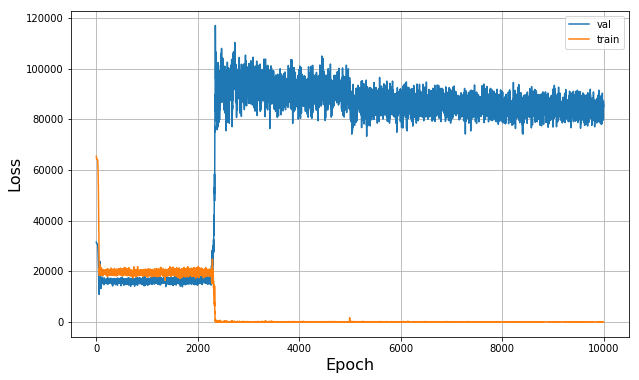

In [101]:
fig = plt.figure(figsize=(10,6))
plt.plot(vloss, label="val")
plt.plot(losses_1, label="train")
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend()
plt.grid()
fig.savefig("cnn_loss_branch.pdf", bbox_inches="tight")